# AC 209a: Predicting the 2020 Election
#### Blake Bullwinkel, Teresa Datta, Victor Avram, Kristen Grabarz

This notebook contains the majority of our project work, including data processing, EDA, modeling, and forecasting. Please see the 
other notebook included in this submission for our analysis of unemployment data, which we used as a proxy for COVID-19 effects.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

## Polling Data
We use historical polling averages from presidential elections from 1972 - 2020. We averaged percentage of voters favoring democratic and republican 
candidates over the course of each election cycle.

In [2]:
pres_polls = pd.read_csv('president_polls.csv')
survey_monkey = pres_polls[pres_polls.pollster == 'SurveyMonkey']
survey_monkey['end_date'] = pd.to_datetime(survey_monkey['end_date'])
survey_monkey.sort_values('end_date', inplace=True)

/opt/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (6,22,25,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cw

To illustrate the time-series data that we will be averaging for each election cycle, these two plots show the polling numbers for Georgia and New York in the weeks 
leading up to the 2020 election.

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


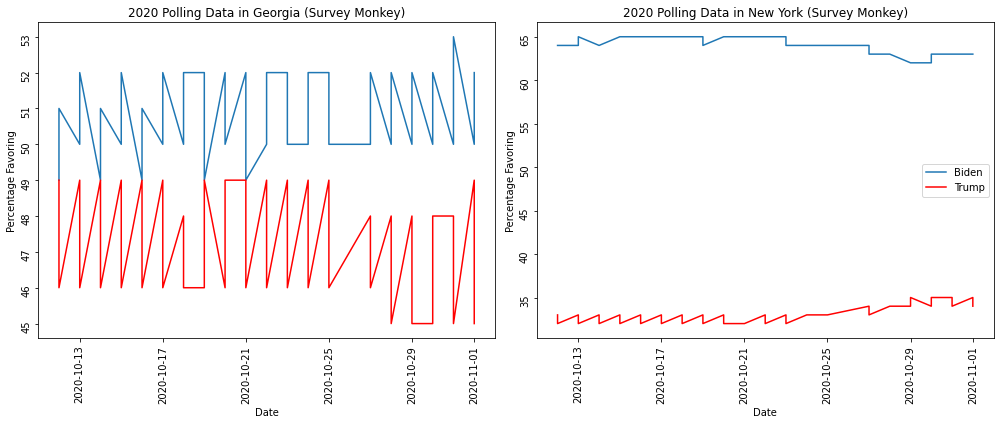

In [3]:
ga_biden = survey_monkey[survey_monkey.state == 'Georgia'][survey_monkey.candidate_name == 'Joseph R. Biden Jr.'].iloc[8:,]
ga_trump = survey_monkey[survey_monkey.state == 'Georgia'][survey_monkey.candidate_name == 'Donald Trump'].iloc[8:,]
ny_biden = survey_monkey[survey_monkey.state == 'New York'][survey_monkey.candidate_name == 'Joseph R. Biden Jr.'].iloc[8:,]
ny_trump = survey_monkey[survey_monkey.state == 'New York'][survey_monkey.candidate_name == 'Donald Trump'].iloc[8:,]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(ga_biden['end_date'], ga_biden['pct'])
ax1.plot(ga_trump['end_date'], ga_trump['pct'], color='red')
ax1.tick_params(rotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Percentage Favoring')
ax1.set_title('2020 Polling Data in Georgia (Survey Monkey)')
ax2.plot(ny_biden['end_date'], ny_biden['pct'])
ax2.plot(ny_trump['end_date'], ny_trump['pct'], color='red')
ax2.tick_params(rotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage Favoring')
ax2.set_title('2020 Polling Data in New York (Survey Monkey)')
ax2.legend(['Biden', 'Trump'])
plt.tight_layout()

Below we show a similar plot with polling averages across all 50 states and Washington D.C. in the months leading up to the 2020 election.

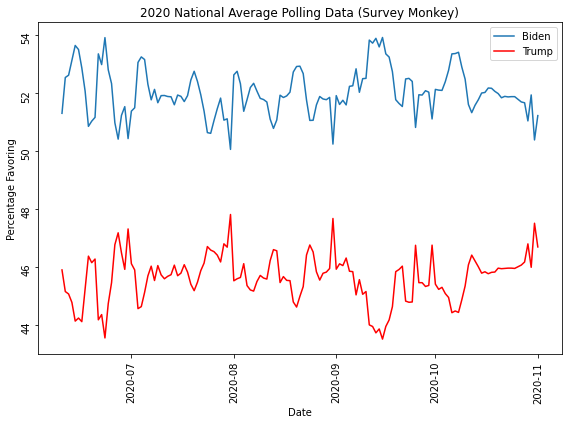

In [4]:
survey_monkey_biden = survey_monkey[survey_monkey.candidate_name == 'Joseph R. Biden Jr.']
survey_monkey_trump = survey_monkey[survey_monkey.candidate_name == 'Donald Trump']
survey_monkey_biden_avg = survey_monkey_biden.groupby(['end_date']).mean()
survey_monkey_trump_avg = survey_monkey_trump.groupby(['end_date']).mean()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(survey_monkey_biden_avg.index, survey_monkey_biden_avg['pct'])
ax.plot(survey_monkey_trump_avg.index, survey_monkey_trump_avg['pct'], color='red')
ax.tick_params(rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel('Percentage Favoring')
ax.set_title('2020 National Average Polling Data (Survey Monkey)')
ax.legend(['Biden', 'Trump'])
plt.tight_layout()

Now we construct a dataframe with the polling averages for each democratic and republican presidential nominee for each state and election cycle from 1972-2016.

In [5]:
# Read in the historical polls data
historical_polls = pd.read_csv('pres_pollaverages_1968-2016.csv')

# Calculate aggregate means grouped by state, election cycle, and candidate
historical_polls = historical_polls.groupby(['state', 'cycle', 'candidate_name'], as_index=False).mean()

# Drop rows with invalid state names
states = sorted([state for state in set(historical_polls['state'].to_numpy()) if state not in ['ME-1','ME-2','NE-1','NE-2','NE-3','National']])
historical_polls = historical_polls[historical_polls.state.isin(states)]

# Drop rows with non-democratic or republican nominees (remove independent candidates)
presidential_nominees = {'George S. McGovern': 'D', 'Richard M. Nixon': 'R', 'Jimmy Carter': 'D', 'Gerald R. Ford': 'R',
                        'Ronald Reagan': 'R', 'Walter F. Mondale': 'D', 'Michael S. Dukakis': 'D', 'George Bush': 'R',
                        'Bill Clinton': 'D', 'Bob Dole': 'R', 'Al Gore': 'D', 'George W. Bush': 'R', 'John Kerry': 'D',
                        'Barack Obama': 'D', 'John McCain': 'R', 'Mitt Romney': 'R', 'Hillary Rodham Clinton': 'D',
                        'Donald Trump': 'R'}
historical_polls = historical_polls[historical_polls.candidate_name.isin(list(presidential_nominees.keys()))]

# Select relevant columns
historical_polls = historical_polls[['state', 'cycle', 'candidate_name', 'pct_estimate']]

# Duplicate the percentage favoring column and create separate columns for democratic and republican
historical_polls['pct_R'] = historical_polls['pct_estimate']
historical_polls = historical_polls.rename(columns = {'pct_estimate': 'pct_D'})

# Create lists of democratic and republican nominees
democratic_nominees = [k for k,v in presidential_nominees.items() if v=='D']
republican_nominees = [k for k,v in presidential_nominees.items() if v=='R']

# Remove democrat values from the republican column and vice versa
historical_polls.pct_D = historical_polls.pct_D.where(historical_polls.candidate_name.isin(democratic_nominees))
historical_polls.pct_R = historical_polls.pct_R.where(historical_polls.candidate_name.isin(republican_nominees))

# Remove the candidate name column and collapse dataframe by grouping by election cycle
historical_polls.drop('candidate_name', axis=1, inplace=True)
historical_polls = historical_polls.groupby(['state', 'cycle'])[['pct_D', 'pct_R']].first().reset_index()

historical_polls

,state,cycle,pct_D,pct_R
0,Alabama,1980,43.208668,40.601435
1,Alabama,1984,41.092588,50.959713
2,Alabama,1988,34.662672,52.483727
3,Alabama,1992,35.158211,39.186728
4,Alabama,1996,39.054904,46.897584
...,...,...,...,...
509,Wyoming,1992,28.834534,34.065528
510,Wyoming,1996,37.431114,43.628130
511,Wyoming,2000,29.856807,58.590792
512,Wyoming,2008,34.096976,56.925639


Using this dataframe, we can now plot each state's polling data for each election cycle. Below we show these plots for California and Pennsylvania.

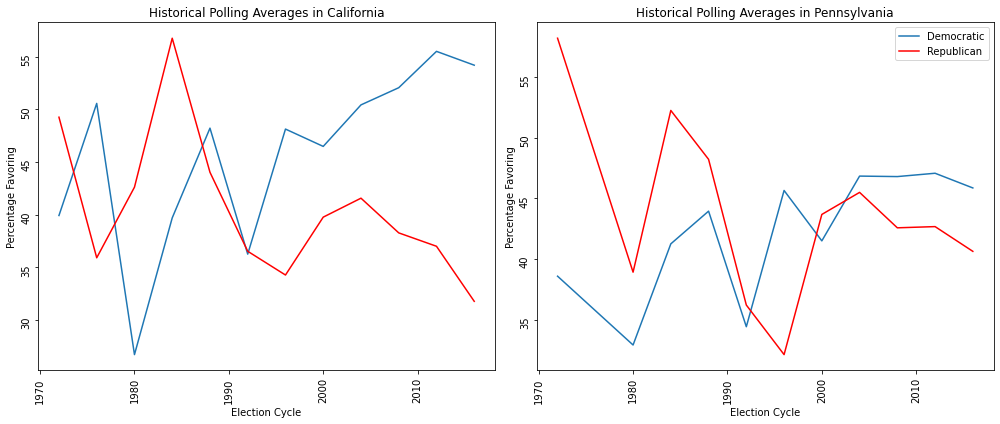

In [6]:
california_polls = historical_polls[historical_polls['state']=='California']
pennsylvania_polls = historical_polls[historical_polls['state']=='Pennsylvania']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(california_polls['cycle'], california_polls['pct_D'])
ax1.plot(california_polls['cycle'], california_polls['pct_R'], color='red')
ax1.tick_params(rotation=90)
ax1.set_xlabel('Election Cycle')
ax1.set_ylabel('Percentage Favoring')
ax1.set_title('Historical Polling Averages in California')
ax2.plot(pennsylvania_polls['cycle'], pennsylvania_polls['pct_D'])
ax2.plot(pennsylvania_polls['cycle'], pennsylvania_polls['pct_R'], color='red')
ax2.tick_params(rotation=90)
ax2.set_xlabel('Election Cycle')
ax2.set_ylabel('Percentage Favoring')
ax2.set_title('Historical Polling Averages in Pennsylvania')
ax2.legend(['Democratic', 'Republican'])
plt.tight_layout()

## Chloropleth Maps

In [7]:
!pip install shapely
!pip install descartes
!pip install geopandas
!pip install folium

import json
import datetime
from shapely.geometry import Polygon, mapping
import geopandas as gpd
import folium
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


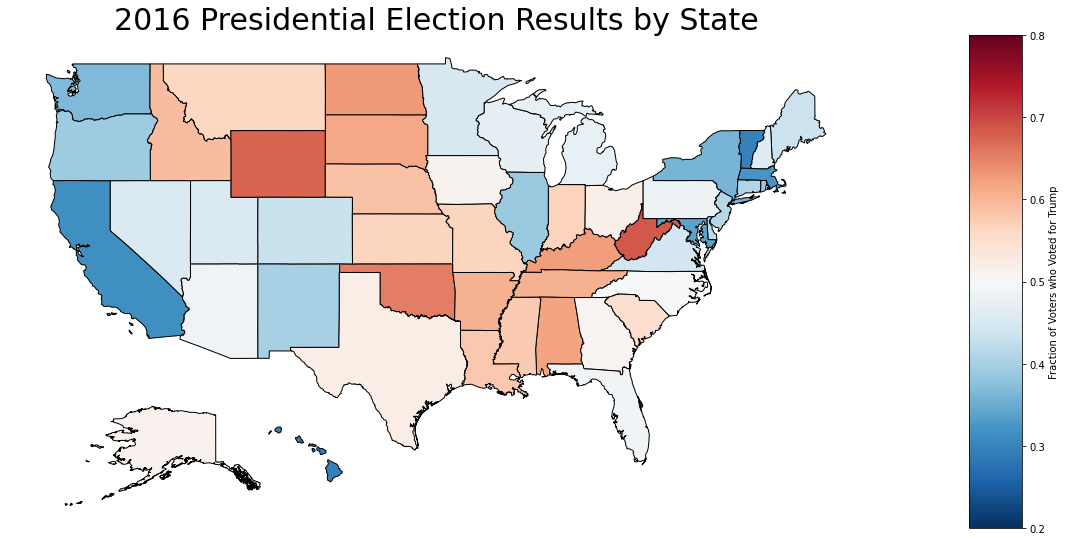

In [8]:
us_shape = gpd.read_file('states_21basic')

#get percent rep for each state for 2016 election
pres_results_16 = pd.read_csv("potus_results_76_16.csv")
pres_results_16 = pres_results_16[pres_results_16.year == 2016]
pres_results_16 = pres_results_16[['state', 'dem', 'rep', 'other']]
pres_results_16.state = pres_results_16.state.astype(str)

#make df that has us_shape (geom, state_fips), joined with pres_results_16 (state, rep)

us_shape_pres16 = us_shape.merge(pres_results_16, how = 'inner', left_on = 'STATE_ABBR', right_on = 'state')
us_shape_pres16 = us_shape_pres16.drop('state', axis = 1)

#lets move and resize alaska and hawaii to make it prettier

ak = us_shape_pres16.STATE_ABBR == "AK"
us_shape_pres16[ak] = us_shape_pres16[ak].set_geometry(us_shape_pres16[ak].scale(.3,.3,.3).translate(38, -36))

hi = us_shape_pres16.STATE_ABBR == "HI"
us_shape_pres16[hi] = us_shape_pres16[hi].set_geometry(us_shape_pres16[hi].translate(52, 5))


fig, gax = plt.subplots(figsize=(20,20))
plt.axis("off")

us_shape_pres16.plot(ax=gax , edgecolor='black', column = 'rep', legend = False, cmap = 'RdBu_r',  vmin = 0.2, vmax = 0.8)

norm = colors.Normalize(vmin=0.2, vmax=0.8)
cbar = plt.cm.ScalarMappable(norm=norm, cmap='RdBu_r')

plt.title("2016 Presidential Election Results by State", fontsize = 30)
divider = make_axes_locatable(gax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax_cbar = fig.colorbar(cbar, cax = cax)
# add label for the colorbar
ax_cbar.set_label('Fraction of Voters who Voted for Trump')


plt.show()

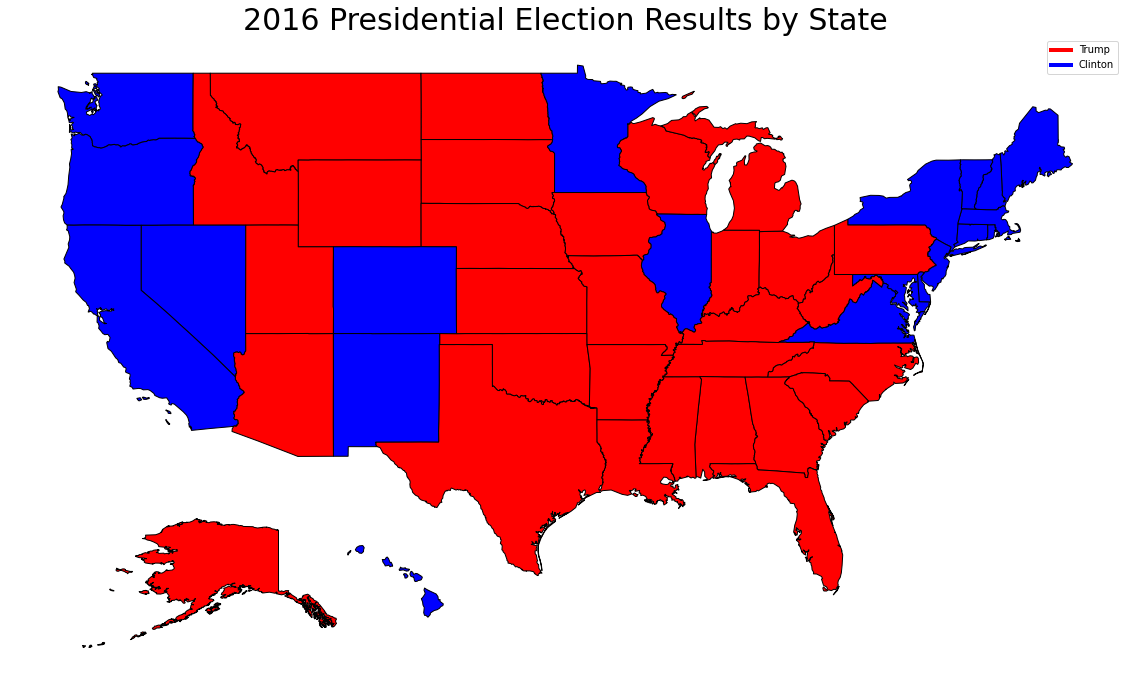

In [9]:
us_shape_pres16['result'] = np.where(us_shape_pres16.rep>us_shape_pres16.dem, 'Trump', 'Clinton')
color_mapping = {'Clinton': '#3C50B1', 'Trump':'#FE433C'}

fig, gax = plt.subplots(figsize=(20,20))
plt.axis("off")

us_shape_pres16.plot(ax=gax , edgecolor='black', color = us_shape_pres16.result.map(color_mapping))

plt.title("2016 Presidential Election Results by State", fontsize = 30)
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="red", lw=4),
                 Line2D([0], [0], color='blue', lw=4)]

gax.legend(custom_lines, ['Trump','Clinton'])


plt.show()

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


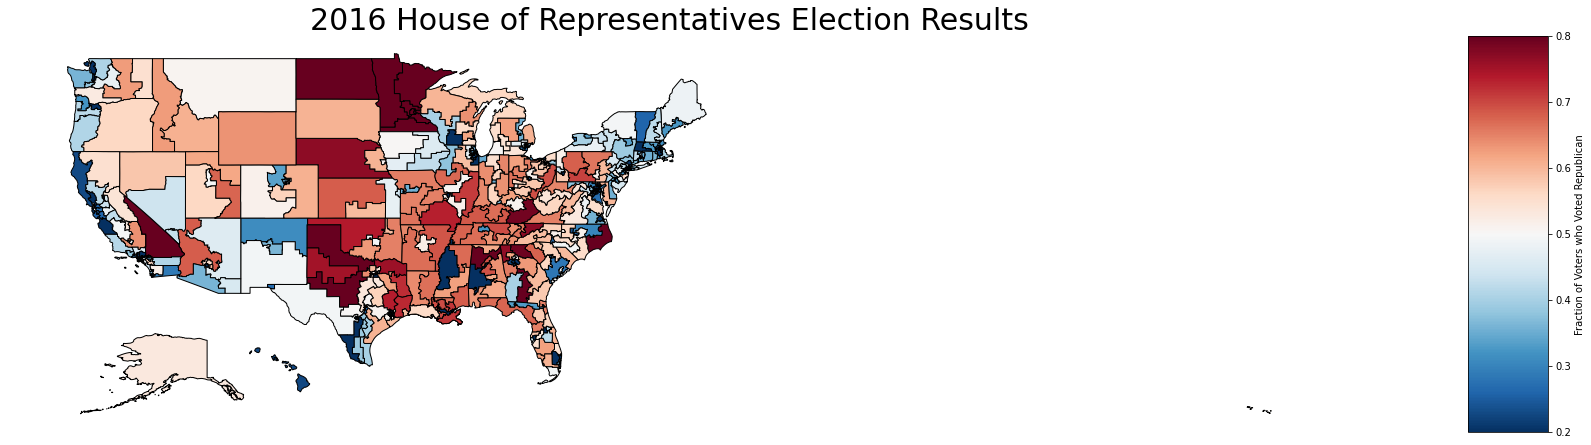

In [10]:
cong_shape = gpd.read_file('cb_2018_us_cd116_20m')
cong_shape.STATEFP = cong_shape.STATEFP.astype(int)
cong_shape.CD116FP = cong_shape.CD116FP.astype(int)

ak = cong_shape.STATEFP == 2
cong_shape[ak] = cong_shape[ak].set_geometry(cong_shape[ak].scale(.3,.3,.3).translate(-70, -36))

hi = cong_shape.STATEFP == 15
cong_shape[hi] = cong_shape[hi].set_geometry(cong_shape[hi].translate(52, 5))

# load in house results df and manipulate to get wanted info

house_reps = pd.read_csv('/home/jovyan/work/house_results_76_18.csv', encoding = "ISO-8859-1")
house_reps18 = house_reps[house_reps['year'] == 2018][house_reps['stage']=='gen']
house_reps18 = house_reps18[['state_fips', 'candidate', 'district', 'party', 'candidatevotes', 'totalvotes']]

house_reps18_rep = house_reps18[house_reps18.party=='republican']
house_reps18_dem = house_reps18[house_reps18.party == 'democrat']
house_reps18 = house_reps18_rep.merge(house_reps18_dem, how = 'outer', left_on=['state_fips', 'district'], right_on = ['state_fips', 'district'])
house_reps18 = house_reps18[['state_fips', 'district', 'candidate_x', 'candidatevotes_x', 'candidate_y', 'candidatevotes_y', 'totalvotes_y']]
house_reps18 = house_reps18.rename({'candidate_x': 'rep_candidate', 'candidatevotes_x':'rep_votes', 'candidate_y': 'dem_candidate', 'candidatevotes_y':'dem_votes', 'totalvotes_y': 'total_votes'}, axis =1)
house_reps18['rep_votes'] = house_reps18['rep_votes'].fillna(0)
house_reps18['dem_votes'] = house_reps18['dem_votes'].fillna(0)
house_reps18['total_votes'] = house_reps18['total_votes'].fillna(house_reps18['rep_votes'] + house_reps18['dem_votes'])
house_reps18['rep'] = house_reps18['rep_votes']/house_reps18['total_votes']
house_reps18['Result'] = np.where(house_reps18.rep_votes>house_reps18.dem_votes, 'red', 'blue')
house_reps18['Result'] = house_reps18['Result'].fillna('E')

cong18_shape = cong_shape.merge(house_reps18, how = 'outer', left_on = ['STATEFP', 'CD116FP'], right_on = ['state_fips', 'district'])
cong18_shape.Result = cong18_shape.Result.fillna('white')

fig, gax = plt.subplots(figsize=(30, 30))
plt.axis("off")

cong18_shape.plot(ax=gax , edgecolor='black', column = 'rep', legend = False, cmap = 'RdBu_r',  vmin = 0.2, vmax = 0.8)

norm = colors.Normalize(vmin=0.2, vmax=0.8)
cbar = plt.cm.ScalarMappable(norm=norm, cmap='RdBu_r')

plt.title("2016 House of Representatives Election Results", fontsize = 30)
divider = make_axes_locatable(gax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax_cbar = fig.colorbar(cbar, cax = cax)
# add label for the colorbar
ax_cbar.set_label('Fraction of Voters who Voted Republican')


plt.show()

In [368]:
# Import the POTUS election results (1976-2016)
outcome_data = pd.read_csv("potus_results_76_16.csv")
print(outcome_data.shape)
print(outcome_data.columns)

# Determine the frequency for each state and assert that each has all observations
year_freq = outcome_data['year'].value_counts()
assert all(year_freq == 51)

# Determine the number of elections spanned by our data
num_elections = len(np.unique(outcome_data['year']))
print(f"This dataset covers {num_elections} presidential races.")

(561, 6)
Index(['year', 'state', 'total_votes', 'dem', 'rep', 'other'], dtype='object')
This dataset covers 11 presidential races.


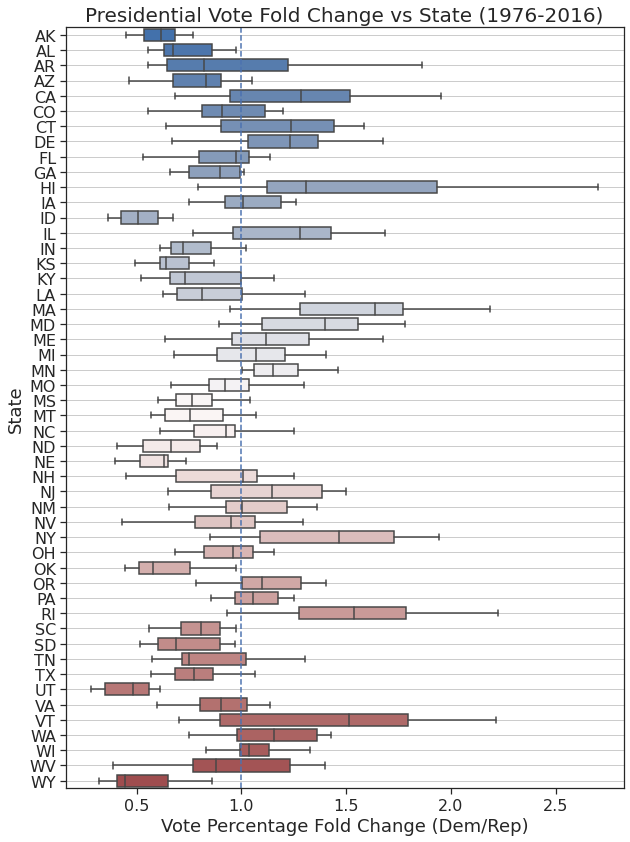

In [28]:
# Calculate the vote fold change (FC > 1 corresponds to a Democratic win and FC < 1 corresponds to a Republican win)
outcome_data['FC'] = outcome_data['dem']/outcome_data['rep']

### Remove DC so that the other states can be easily visualized ###
outcome_no_DC = outcome_data[outcome_data['state'] != 'DC']

# Create horizontal boxplots of presidential race vote fold change vs state
fig, ax = plt.subplots(figsize = (10,14))
sns.boxplot(x = 'FC', y = 'state', data = outcome_no_DC, palette = "vlag", ax = ax, showfliers = False)
ax.axvline(x = 1, c = 'b', linestyle = '--')
ax.set_xlabel('Vote Percentage Fold Change (Dem/Rep)', fontsize = 18)
ax.set_ylabel('State', fontsize = 18)
ax.set_title('Presidential Vote Fold Change vs State (1976-2016)', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.grid(True);

In [29]:
# Create a dataframe that stores the vote fold change for each state (states are columns)
state_list = np.unique(outcome_data['state'])
year_list = np.unique(outcome_data['year'])
vote_FC_df = pd.DataFrame(columns=state_list, index = year_list)
for state in state_list:
    vote_FC_df[state] = np.array(outcome_data['FC'][outcome_data['state'] == state])

#print(vote_FC_df.head)

In [30]:
# Create a vote fold change correlation matrix 
corr_matrix = vote_FC_df.corr()
# Create a matrix with the coefficient of determination values
r2_matrix = corr_matrix**2

#### Clustered $R$ and $R^2$ matrices
Useful for final prediction imputation.

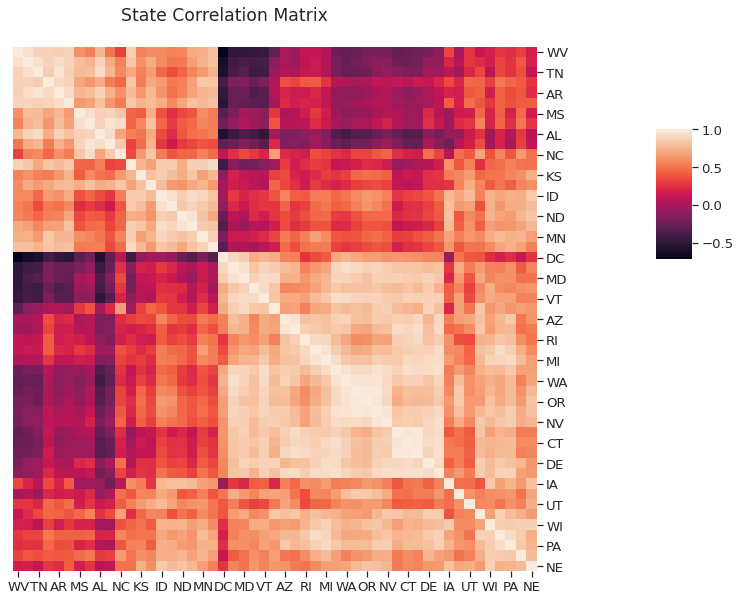

In [31]:
# Create a correlation matrix with truncated values
corr_matrix_trunc = np.round(corr_matrix, 3)
# Create a heatmap for the correlation matrix (using hierarchical clustering)
sns.set(font_scale=1.2)
sns.set_style("ticks")
cluster_map = sns.clustermap(corr_matrix_trunc, cbar_pos=(1.1, 0.5, 0.05, 0.18))
plt.setp(cluster_map.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
plt.setp(cluster_map.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cluster_map.ax_row_dendrogram.set_visible(False)
cluster_map.ax_col_dendrogram.set_visible(False)
cluster_map.fig.suptitle('State Correlation Matrix', y=.85);

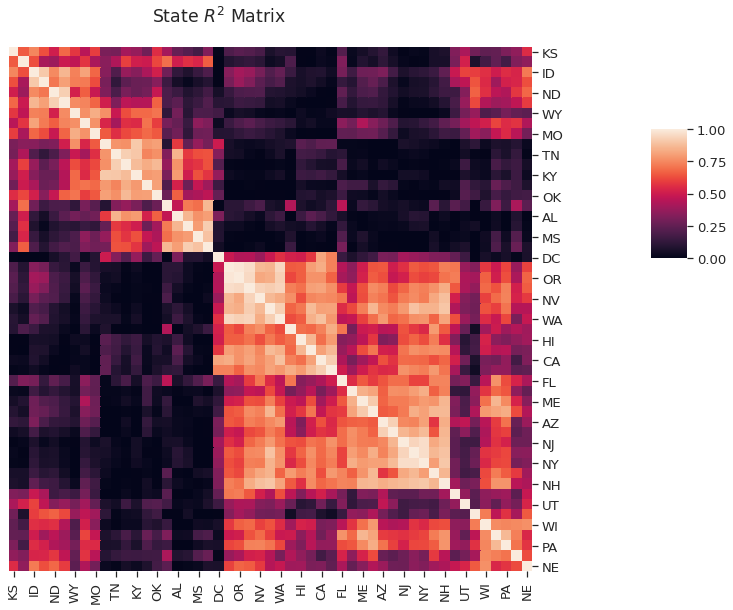

In [32]:
# Create a r2 matrix with truncated values
r2_matrix_trunc = np.round(r2_matrix, 3)
# Create a heatmap for the matrix with r2 values (using hierarchical clustering)
sns.set(font_scale=1.2)
sns.set_style("ticks")
cluster_map = sns.clustermap(r2_matrix_trunc, cbar_pos=(1.1, 0.5, 0.05, 0.18))
plt.setp(cluster_map.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(cluster_map.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cluster_map.ax_row_dendrogram.set_visible(False)
cluster_map.ax_col_dendrogram.set_visible(False)
cluster_map.fig.suptitle('State $R^2$ Matrix', y=.85);

---
## Baseline Model - POTUS

In [33]:
# 1. make table!

# - starting from potus_results_76_16
potus_results = pd.read_csv('potus_results_76_16.csv')

# - create "foldchange" results var (# Dem votes/ # Rep votes)
#    - if "foldchange" > 1: Dem win, else: Rep win
potus_results['foldchange'] = potus_results['dem']/potus_results['rep']

#handle bad data cases where foldchange is 0 or infinite--> potentially switch to scaler
potus_results['foldchange'] = np.where((potus_results.foldchange> 9), 10, potus_results.foldchange)
potus_results['foldchange'] = np.where((potus_results.foldchange< 0.005), 0.001, potus_results.foldchange)

potus_results = potus_results.drop(['dem', 'rep', 'other'], axis = 1)
potus_results.head()

# Create lagged variables based on outcome of previous two elections
potus_results['lagged_FC'] = potus_results.groupby('state')['foldchange'].shift()
potus_results['twice_lagged_FC'] = potus_results.groupby('state')['foldchange'].shift(periods=2)

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, 'Election Fold Change (% Dem Votes / % Rep Votes)')

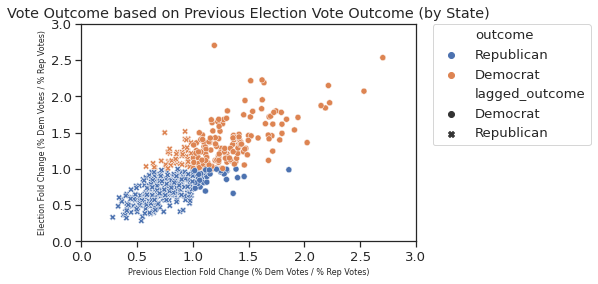

In [34]:
# Create scatter of prev election vs. present

potus_results['outcome'] = 'Democrat'
potus_results['outcome'][potus_results['foldchange']<1] = 'Republican'
potus_results['lagged_outcome'] = 'Democrat'
potus_results['lagged_outcome'][potus_results['lagged_FC']<1] = 'Republican'

# Plot
sns.scatterplot(x="lagged_FC", y="foldchange", data=potus_results, hue='outcome', legend=True, style = 'lagged_outcome')
plt.title('Vote Outcome based on Previous Election Vote Outcome (by State)')
# Set x-axis label
plt.xlabel('Previous Election Fold Change (% Dem Votes / % Rep Votes)')
# Set y-axis label
plt.ylabel('Election Fold Change (% Dem Votes / % Rep Votes)')

# Create alt version focusing on < 3
sns.scatterplot(x="lagged_FC", y="foldchange", data=potus_results, hue='outcome', legend=False, style = 'lagged_outcome')
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Vote Outcome based on Previous Election Vote Outcome (by State)')
# Set x-axis label
plt.xlabel('Previous Election Fold Change (% Dem Votes / % Rep Votes)', fontsize=8)
# Set y-axis label
plt.ylabel('Election Fold Change (% Dem Votes / % Rep Votes)', fontsize=8)


In [73]:
historical_polls.head()

,state,cycle,pct_D,pct_R
0,1,1980,43.208668,40.601435
1,1,1984,41.092588,50.959713
2,1,1988,34.662672,52.483727
3,1,1992,35.158211,39.186728
4,1,1996,39.054904,46.897584


In [42]:
# Import the Abramowitz data
a = pd.read_csv('abramowitz_data.csv')
# Merge the Abramowitz data with the POTUS results (on year)
data = potus_results.merge(a, how='inner', on='year')

### convert string and object variables to numbers :-(

# drop outcome and lagged outcome and label
data = data.drop(['outcome', 'lagged_outcome', 'label'], axis = 1)

# convert state -> state fips
state_fips = {
    'WA': 53, 'DE': 10, 'DC': 11, 'WI': 55, 'WV': 54, 'HI': 15,
    'FL': 12, 'WY': 56, 'PR': 72, 'NJ': 34, 'NM': 35, 'TX': 48,
    'LA': 22, 'NC': 37, 'ND': 38, 'NE': 31, 'TN': 47, 'NY': 36,
    'PA': 42, 'AK': 2, 'NV': 32, 'NH': 33, 'VA': 51, 'CO': 8,
    'CA': 6, 'AL': 1, 'AR': 5, 'VT': 50, 'IL': 17, 'GA': 13,
    'IN': 18, 'IA': 19, 'MA': 25, 'AZ': 4, 'ID': 16, 'CT': 9,
    'ME': 23, 'MD': 24, 'OK': 40, 'OH': 39, 'UT': 49, 'MO': 29,
    'MN': 27, 'MI': 26, 'RI': 44, 'KS': 20, 'MT': 30, 'MS': 28,
    'SC': 45, 'KY': 21, 'OR': 41, 'SD': 46
}
state_name_fips = {
    'Washington': 53, 'Delaware': 10, 'District of Columbia': 11, 'Wisconsin': 55, 'West Virginia': 54, 'Hawaii': 15,
    'Florida': 12, 'Wyoming': 56, 'Puerto Rico': 72, 'New Jersey': 34, 'New Mexico': 35, 'Texas': 48,
    'Louisiana': 22, 'North Carolina': 37, 'North Dakota': 38, 'Nebraska': 31, 'Tennessee': 47, 'New York': 36,
    'Pennsylvania': 42, 'Alaska': 2, 'Nevada': 32, 'New Hampshire': 33, 'Virginia': 51, 'Colorado': 8,
    'California': 6, 'Alabama': 1, 'Arkansas': 5, 'Vermont': 50, 'Illinois': 17, 'Georgia': 13,
    'Indiana': 18, 'Iowa': 19, 'Massachusetts': 25, 'Arizona': 4, 'Idaho': 16, 'Connecticut': 9,
    'Maine': 23, 'Maryland': 24, 'Oklahoma': 40, 'Ohio': 39, 'Utah': 49, 'Missouri': 29,
    'Minnesota': 27, 'Michigan': 26, 'Rhode Island': 44, 'Kansas': 20, 'Montana': 30, 'Mississippi': 28,
    'South Carolina': 45, 'Kentucky': 21, 'Oregon': 41, 'South Dakota': 46
}
data['state'] = data['state'].replace(state_fips)
historical_polls['state'] = historical_polls['state'].replace(str(state_name_fips))

#convert wonlost
data['wonlost'] = data['wonlost'].astype('category').cat.codes

# convert inc
data['inc'] = data['inc'].astype('category').cat.codes

#convert june app2
data['juneapp2'] = data['juneapp2'].astype('category').cat.codes

# convert filter_.
data['filter_.'] = data['filter_.'].astype('category').cat.codes

# join 'historical_polls' on 'data'
data = pd.merge(data, historical_polls, how='left', left_on=['year', 'state'], right_on=['cycle', 'state'])

# find cols that have nan, check what percent of rows have nan
# data.isnull().sum(axis=0)
#  fill lagged_FC, twice_lagged_FC, and predincvote with knn imputer 

imputer = KNNImputer(n_neighbors = 3)
data = pd.DataFrame(imputer.fit_transform(data),columns = data.columns)

data.head()

,year,state,total_votes,foldchange,lagged_FC,twice_lagged_FC,deminc,popmargin,demvote,incvotemargin,...,juneapp,term1,term2,dmargin,juneapp2,filter_.,predincvote,cycle,pct_D,pct_R
0,1976.0,2.0,123574.0,0.615722,2.077167,2.298495,0.0,2.2,51.1,-2.2,...,5.0,0.0,1.0,2.2,1.0,1.0,50.583111,1992.000000,46.308234,29.883876
1,1976.0,1.0,1182850.0,1.307695,0.807164,0.622139,0.0,2.2,51.1,-2.2,...,5.0,0.0,1.0,2.2,1.0,1.0,50.583111,1992.000000,30.646527,43.945655
2,1976.0,5.0,767535.0,1.861136,0.839886,0.882954,0.0,2.2,51.1,-2.2,...,5.0,0.0,1.0,2.2,1.0,1.0,50.583111,2006.666667,33.525628,51.736958
3,1976.0,4.0,742719.0,0.706097,0.906804,1.075066,0.0,2.2,51.1,-2.2,...,5.0,0.0,1.0,2.2,1.0,1.0,50.583111,2004.000000,38.063969,39.313685
4,1976.0,6.0,7803770.0,0.963949,1.347752,1.360126,0.0,2.2,51.1,-2.2,...,5.0,0.0,1.0,2.2,1.0,1.0,50.583111,1976.000000,50.570579,35.888211


In [43]:
# Combine the columns indicating percentage Democrat and percentage Republican
data['poll_FC'] = data['pct_D']/data['pct_R']  # Greater than 1 is a win for Democrat
#data = data.drop(['pct_D', 'pct_R'], axis=1)

#### Overview of the data
Each sample in our data is a unique state,year pair for years ranging from 1976 to 2016. Some of the data is state, year specific 
(e.g. `total votes`, `lagged_FC`) and some of the data is year specific (e.g. `eygdp`, `q2gdp`). For our baseline model, we will capitalize on the correlation between 
individual states' voting outcomes year over year by using each state's two previous election results as predictors, along with core economic
and political factors such as GDP growth at the end of the previous year and in the second quarter of election year, whether an incumbent is running, and 
the approval rating of the current sitting president. Based on our research, these factors have been identified in political science research as being independently indicative
of the popular vote in presidential elections.

In [39]:
# Time to Model! 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #for classification
from sklearn.neighbors import KNeighborsRegressor #for regression
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score

#### POTUS Logistic Regression Model (Predicting Win) - Baseline Logistic Model

In [390]:
# Create binary outcome variable from foldchange

# Define the predictors and response for this baseline logistic regression model
X = data[['lagged_FC', 'twice_lagged_FC', 'q2gdp', 'inc', 'juneapp']]
y = np.where(data['foldchange'] > 1, 1, 0)  # The response is a binary variable indicating win (1 for Dem win and 0 for Rep win)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=109)
#X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y,train_size=0.8,random_state=109)

In [391]:
# Initialize the logistic regression model
logit = LogisticRegression(penalty='none', max_iter = 1000)

# Fit the model using the training set
logit.fit(X_train,y_train)

# Predict the y values for the training set and test set
y_train_pred = logit.predict(X_train)
y_test_pred = logit.predict(X_test)

# Calculate the accuracy score for the training set and test set
train_accuracy = accuracy_score(y_train,y_train_pred)
test_accuracy = accuracy_score(y_test,y_test_pred)

print(f"The classification accuracy for the training data is {train_accuracy:0.5f}.")
print(f"The classification accuracy for the test data is {test_accuracy:0.5f}.")

The classification accuracy for the training data is 0.83929.
The classification accuracy for the test data is 0.83186.


### Iterating on POTUS Logistic Regression Model
Polling Data has been added to the dataset. 

#### Lasso Regularization

In [481]:
# Create binary outcome variable from foldchange

# Define the predictors and response for this baseline logistic regression model
X = data[['lagged_FC', 'twice_lagged_FC', 'q2gdp', 'inc', 'juneapp', 'poll_FC']]
y = np.where(data['foldchange'] > 1, 1, 0)  # The response is a binary variable indicating win (1 for Dem win and 0 for Rep win)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=109)

In [482]:
# Define the values of C for the Lasso-like logistic regression model
exponents = np.linspace(-4,4,9)
C_list = 10**exponents

# Initialize lists to store the mean accuracy score for the training and validation sets for each iteration
train_accuracy_list,val_accuracy_list = [],[]

# Iterate over the values of C
for C in C_list:
    
    # Initialize the logistic regression model
    logit_lasso = LogisticRegression(penalty='l1', C=C, max_iter=1000, solver='liblinear')
    
    # Perform 3-fold cross-validation
    cross_val_model = cross_validate(logit_lasso, X_train, y_train, cv=3,
                                     scoring='accuracy', return_train_score=True)
    
    # Pull the accuracy score for the training set
    train_accuracy = np.abs(cross_val_model['train_score'])
    # Pull the accuracy score for the validation set
    val_accuracy = np.abs(cross_val_model['test_score'])

    # Append the mean training accuracy score to the train MSE list
    train_accuracy_list.append(train_accuracy.mean())
    # Append the mean validation accuracy score to the validation MSE list
    val_accuracy_list.append(val_accuracy.mean())

In [483]:
# Determine the the largest accuracy score on the validation set
max_index = np.argmax(val_accuracy_list)
# Find the associated C
best_C = C_list[max_index]

# Initialize the logistic regression model
logit_lasso = LogisticRegression(penalty='l1', C=best_C, max_iter=1000, solver='liblinear')

# Fit the model using the training set
logit_lasso.fit(X_train,y_train)

# Predict y values for the training set and test set
y_train_pred = logit_lasso.predict(X_train)
y_test_pred = logit_lasso.predict(X_test)

# Calculate the accuracy score for the training set and test set
train_accuracy = accuracy_score(y_train,y_train_pred)
test_accuracy = accuracy_score(y_test,y_test_pred)

# Pull the coefficients of the model
lasso_beta0 = logit_lasso.intercept_[0]
lasso_coefficients = logit_lasso.coef_[0]

predictors = ', '.join(X_train.columns)

print(f"The best C based on the validation set accuracy scores is {best_C}.")
print(f"The accuracy score for the training set is {train_accuracy:0.5f}.")
print(f"The accuracy score for the test set is {test_accuracy:0.5f}.")
print(f"The intercpet for the model is {lasso_beta0:0.5f}.")
print(f"The remaining coefficients for {predictors} are as follows in order:")
print(np.around(lasso_coefficients,5))

The best C based on the validation set accuracy scores is 1.0.
The accuracy score for the training set is 0.86607.
The accuracy score for the test set is 0.83186.
The intercpet for the model is -9.13804.
The remaining coefficients for lagged_FC, twice_lagged_FC, q2gdp, inc, juneapp, poll_FC are as follows in order:
[ 4.13009 -0.8473   0.23907  0.12831 -0.06148  4.5161 ]


#### Ridge Regularization

In [484]:
# Define the values of C for the Ridge-like logistic regression model
exponents = np.linspace(-4,4,9)
C_list = 10**exponents

# Initialize lists to store the mean accuracy score for the training and validation sets for each iteration
train_accuracy_list,val_accuracy_list = [],[]

# Iterate over the values of C
for C in C_list:
    
    # Initialize the logistic regression model
    logit_ridge = LogisticRegression(penalty='l2', C=C, max_iter=1000, solver='liblinear')
    
    # Perform 3-fold cross-validation
    cross_val_model = cross_validate(logit_ridge, X_train, y_train, cv=3,
                                     scoring='accuracy', return_train_score=True)
    
    # Pull the accuracy score for the training set
    train_accuracy = np.abs(cross_val_model['train_score'])
    # Pull the accuracy score for the validation set
    val_accuracy = np.abs(cross_val_model['test_score'])

    # Append the mean training accuracy score to the train MSE list
    train_accuracy_list.append(train_accuracy.mean())
    # Append the mean validation accuracy score to the validation MSE list
    val_accuracy_list.append(val_accuracy.mean())

In [485]:
# Determine the the largest accuracy score on the validation set
max_index = np.argmax(val_accuracy_list)
# Find the associated C
best_C = C_list[max_index]

# Initialize the logistic regression model
logit_ridge = LogisticRegression(penalty='l2', C=best_C, max_iter=1000, solver='liblinear')

# Fit the model using the training set
logit_ridge.fit(X_train,y_train)

# Predict y values for the training set and test set
y_train_pred = logit_ridge.predict(X_train)
y_test_pred = logit_ridge.predict(X_test)

# Calculate the accuracy score for the training set and test set
train_accuracy = accuracy_score(y_train,y_train_pred)
test_accuracy = accuracy_score(y_test,y_test_pred)

# Pull the coefficients of the model
ridge_beta0 = logit_ridge.intercept_[0]
ridge_coefficients = logit_ridge.coef_[0]

predictors = ', '.join(X_train.columns)

print(f"The best C based on the validation set accuracy scores is {best_C}.")
print(f"The accuracy score for the training set is {train_accuracy:0.5f}.")
print(f"The accuracy score for the test set is {test_accuracy:0.5f}.")
print(f"The intercpet for the model is {ridge_beta0:0.5f}.")
print(f"The remaining coefficients for {predictors} are as follows in order:")
print(np.around(ridge_coefficients,5))

The best C based on the validation set accuracy scores is 10.0.
The accuracy score for the training set is 0.87723.
The accuracy score for the test set is 0.83186.
The intercpet for the model is -9.54586.
The remaining coefficients for lagged_FC, twice_lagged_FC, q2gdp, inc, juneapp, poll_FC are as follows in order:
[ 4.63243 -1.3132   0.24651  0.17516 -0.06295  4.81835]


#### ROC Curves for Lasso and Ridge Regularized Models

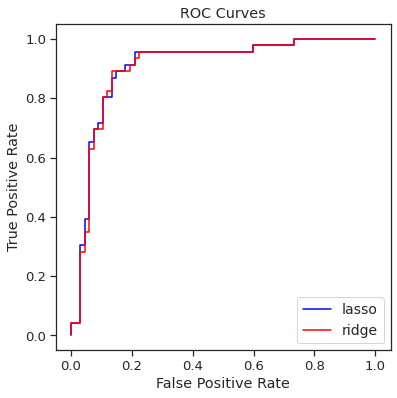

In [488]:
from sklearn.metrics import roc_curve

# Compute the predicted probabilities of Democratic win

logit_lasso_pred = logit_lasso.predict_proba(X_test)[:,1]
logit_ridge_pred = logit_ridge.predict_proba(X_test)[:,1]

# Compute the false positive rates and true positive rates used for the ROC curves
lasso_fpr, lasso_tpr, lasso_threshold = roc_curve(y_test, logit_lasso_pred)
ridge_fpr, ridge_tpr, ridge_threshold = roc_curve(y_test, logit_ridge_pred)

# Create a plot of the ROC curves for both regularized models
fig, ax = plt.subplots(figsize = (6,6))
ax.plot(lasso_fpr, lasso_tpr, color = 'blue', label = 'lasso')
ax.plot(ridge_fpr, ridge_tpr, color = 'red', label = 'ridge')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend(fontsize=14);

#### POTUS k-NN Model (Predicting Fold Change)- Regression

In [127]:
k_value_min = 1
k_value_max = 20

# creating list of integer k values betwwen k_value_min and k_value_max using linspace
k_list = np.linspace(k_value_min,k_value_max,num=20,dtype=int)

# Define the predictors and response for this baseline model
#X = data.drop(['foldchange'], axis = 1)
X = data[['lagged_FC', 'twice_lagged_FC', 'eygdp', 'q2gdp', 'inc', 'juneapp']]
y = data['foldchange']



In [124]:
def knn_optimizer(k_list, X, y):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=109)
    
    # creating a dictionary for storing k value against MSE of cv
    knn_dict = {}
    j=0

    for k_value in k_list:   

        # Initialize the KNN regression model 
        k_value = int(k_value)
        knn_model = KNeighborsRegressor(n_neighbors=k_value)
            

        # Perform 3-fold cross-validation
        cross_val_model = cross_validate(knn_model, X_train, y_train, cv=3,
                                        scoring='neg_mean_squared_error', return_train_score=True)

        # Pull the accuracy score for the validation set
        val_mse = np.abs(np.mean(cross_val_model['test_score']))
        knn_dict[k_value] = val_mse

    min_mse = min(knn_dict.values())
    best_model = 0
    for k in knn_dict.keys():
        if (knn_dict[k] == min_mse):
            best_model = k     
    model = KNeighborsRegressor(n_neighbors=best_model)
    model.fit(X_train,y_train)
    y_pred_test = model.predict(X_test)

    print ("The best k value is ",best_model,"with a cross val MSE of ", min_mse)
    print(f"The R2 score for your model is {r2_score(y_test, y_pred_test)}")
    print(f"The MSE for your model is {mean_squared_error(y_test, y_pred_test)}")

    

In [128]:
knn_optimizer(k_list, X, y)

The best k value is  1 with a cross val MSE of  0.7895937838314193
The R2 score for your model is 0.9665646180466957
The MSE for your model is 0.051595261582176234


## Iterating on POTUS KNN Model - Regression

In [87]:
data.head()

,year,state,total_votes,foldchange,lagged_FC,twice_lagged_FC,deminc,popmargin,demvote,incvotemargin,...,term1,term2,dmargin,juneapp2,filter_.,predincvote,cycle,pct_D,pct_R,poll_FC
0,1976.0,2.0,123574.0,0.615722,2.077167,2.298495,0.0,2.2,51.1,-2.2,...,0.0,1.0,2.2,1.0,1.0,50.583111,1992.000000,46.308234,29.883876,1.549606
1,1976.0,1.0,1182850.0,1.307695,0.807164,0.622139,0.0,2.2,51.1,-2.2,...,0.0,1.0,2.2,1.0,1.0,50.583111,1992.000000,30.646527,43.945655,0.697373
2,1976.0,5.0,767535.0,1.861136,0.839886,0.882954,0.0,2.2,51.1,-2.2,...,0.0,1.0,2.2,1.0,1.0,50.583111,2006.666667,33.525628,51.736958,0.648002
3,1976.0,4.0,742719.0,0.706097,0.906804,1.075066,0.0,2.2,51.1,-2.2,...,0.0,1.0,2.2,1.0,1.0,50.583111,2004.000000,38.063969,39.313685,0.968212
4,1976.0,6.0,7803770.0,0.963949,1.347752,1.360126,0.0,2.2,51.1,-2.2,...,0.0,1.0,2.2,1.0,1.0,50.583111,1976.000000,50.570579,35.888211,1.409114


#### scale data using Standard Scaler for optimizing distance-based algorithm

In [231]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# transform data
data_X = data #data.drop(['foldchange'], axis = 1)
scaled_data = scaler.fit_transform(data_X)
scaled_data = pd.DataFrame(scaled_data, columns = data_X.columns)

In [228]:
X = scaled_data[['lagged_FC', 'twice_lagged_FC', 'eygdp', 'q2gdp', 'inc', 'juneapp']]
y = data['foldchange']

knn_optimizer(k_list, X, y)

The best k value is  4 with a cross val MSE of  0.2076560052810337
The R2 score for your model is 0.971075108278198
The MSE for your model is 0.044634972518237094


#### Feature Selection Exploration 

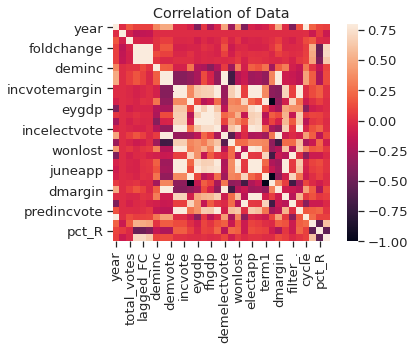

In [232]:
data_corr = scaled_data.corr()
sns.heatmap(data_corr, vmax=.8, square=True)
plt.title("Correlation of Data")
plt.show()

In [233]:
foldchange_corr = data_corr.iloc[3]
pos_corr_feat = []
neg_corr_feat = []
for col in data.columns: 
    # get high positive correlation
    # get high negative correlation
    if foldchange_corr[col] > 0.4: 
        pos_corr_feat.append((col, foldchange_corr[col]))
    elif foldchange_corr[col]<-0.4:
        neg_corr_feat.append((col, foldchange_corr[col]))

print("High Positive Correlation features: ", pos_corr_feat)
print("High Negative Correlation features: ", neg_corr_feat)

High Positive Correlation features:  [('foldchange', 1.0), ('lagged_FC', 0.9353080544994553), ('twice_lagged_FC', 0.8910657473305832), ('pct_D', 0.5292144160168848), ('poll_FC', 0.7075198328719303)]
High Negative Correlation features:  [('pct_R', -0.5165839823326221)]


In [145]:
X = scaled_data[['lagged_FC']]
y = data['foldchange']

knn_optimizer(k_list, X, y)

The best k value is  2 with a cross val MSE of  0.19917830700207695
The R2 score for your model is 0.9454503493067585
The MSE for your model is 0.08417739927914852


In [152]:
X = scaled_data[['lagged_FC', 'twice_lagged_FC', 'poll_FC']]
y = data['foldchange']

knn_optimizer(k_list, X, y)


The best k value is  4 with a cross val MSE of  0.2211495517626364
The R2 score for your model is 0.9556420796587805
The MSE for your model is 0.06845019765118546


In [352]:
X = scaled_data[['lagged_FC', 'twice_lagged_FC', 'q2gdp', 'inc', 'juneapp', 'poll_FC']]
y = data['foldchange']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=109)
knn_pres_model = KNeighborsRegressor(n_neighbors=4)
knn_pres_model.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=4)

## Baseline Model - House of Reps

In [338]:
# We employ a similar approach as in our POTUS base model
# 1. make table!

# - starting from house_results_76_16, manipulate to get into desired format
house_results = pd.read_csv('house_results_76_18.csv', encoding = "ISO-8859-1")
house_results = house_results[house_results['stage']=='gen']
house_results = house_results[['year', 'state_po', 'district', 'party', 'candidatevotes', 'totalvotes']]

house_res_rep = house_results[house_results.party=='republican']
house_res_dem = house_results[house_results.party == 'democrat']
house_results = house_res_rep.merge(house_res_dem, how = 'outer', left_on=['year', 'state_po', 'district'], right_on = ['year', 'state_po', 'district'])
house_results = house_results[['year','state_po', 'district', 'candidatevotes_x', 'candidatevotes_y', 'totalvotes_y']]
house_results = house_results.rename({ 'year':'year', 'candidatevotes_x':'rep_votes',  'candidatevotes_y':'dem_votes', 'totalvotes_y': 'total_votes'}, axis =1)
house_results['rep_votes'] = house_results['rep_votes'].fillna(1)
house_results['dem_votes'] = house_results['dem_votes'].fillna(1)
house_results['total_votes'] = house_results['total_votes'].fillna(house_results['rep_votes'] + house_results['dem_votes'])

# - create "foldchange" results var (# Dem votes/ # Rep votes)
#    - if "foldchange" > 1: Dem win, else: Rep win
house_results['foldchange'] = house_results['dem_votes']/house_results['rep_votes']

# due to some missing data, some of the foldchange values are close to inf or 0 (missing vote totals)
#df['Event'] = np.where((df.Event == 'Painting'),'Art',df.Event)

house_results['foldchange'] = np.where((house_results.foldchange> 10), 11, house_results.foldchange)
house_results['foldchange'] = np.where((house_results.foldchange< 0.0005), 0.0001, house_results.foldchange)

house_results = house_results.drop(['dem_votes', 'rep_votes'], axis = 1)

# Create lagged variables based on outcome of previous two elections
house_results['lagged_FC'] = house_results.groupby(['state_po', 'district'])['foldchange'].shift()
house_results['twice_lagged_FC'] = house_results.groupby(['state_po', 'district'])['foldchange'].shift(periods = 2)
house_results['year_to_merge'] = house_results['year'].apply(lambda x: x if (x%4 ==0) else x-2)

#house_results[house_results.state_po == "TX"][house_results.year ==2018].head()
house_results.head()

,year,state_po,district,total_votes,foldchange,lagged_FC,twice_lagged_FC,year_to_merge
0,1976,AL,1,157170.0,0.599509,NaN,NaN,1976
1,1976,AL,2,156362.0,0.735969,NaN,NaN,1976
2,1976,AL,4,176022.0,4.097478,NaN,NaN,1976
3,1976,AL,6,162518.0,0.753249,NaN,NaN,1976
4,1976,AK,0,118208.0,0.408423,NaN,NaN,1976


In [339]:
# Merge the Abramowitz data with the house results (on year)
house_data = house_results.merge(a, how='inner', left_on='year_to_merge', right_on = 'year')

### convert string and object variables to numbers :-(

house_data['state_po'] = house_data['state_po'].replace(state_fips)

#convert wonlost
house_data['wonlost'] = house_data['wonlost'].astype('category').cat.codes

# convert inc
house_data['inc'] = house_data['inc'].astype('category').cat.codes

#convert june app2
house_data['juneapp2'] = house_data['juneapp2'].astype('category').cat.codes

# convert filter_.
house_data['filter_.'] = house_data['filter_.'].astype('category').cat.codes

# find cols that have nan, check what percent of rows have nan
# data.isnull().sum(axis=0)
#  fill lagged_FC, twice_lagged_FC, and predincvote with knn imputer 

imputer = KNNImputer(n_neighbors = 3)
house_data = pd.DataFrame(imputer.fit_transform(house_data),columns = house_data.columns)

house_data.head()

,year_x,state_po,district,total_votes,foldchange,lagged_FC,twice_lagged_FC,year_to_merge,year_y,label,...,wonlost,inc,electapp,juneapp,term1,term2,dmargin,juneapp2,filter_.,predincvote
0,1976.0,1.0,1.0,157170.0,0.599509,1.308903,1.328440,1976.0,1976.0,76.0,...,0.0,1.0,5.0,5.0,0.0,1.0,2.2,1.0,1.0,50.583111
1,1976.0,1.0,2.0,156362.0,0.735969,2.036786,1.958645,1976.0,1976.0,76.0,...,0.0,1.0,5.0,5.0,0.0,1.0,2.2,1.0,1.0,50.583111
2,1976.0,1.0,4.0,176022.0,4.097478,1.781652,1.656708,1976.0,1976.0,76.0,...,0.0,1.0,5.0,5.0,0.0,1.0,2.2,1.0,1.0,50.583111
3,1976.0,1.0,6.0,162518.0,0.753249,1.482746,1.040017,1976.0,1976.0,76.0,...,0.0,1.0,5.0,5.0,0.0,1.0,2.2,1.0,1.0,50.583111
4,1976.0,2.0,0.0,118208.0,0.408423,0.992709,0.739425,1976.0,1976.0,76.0,...,0.0,1.0,5.0,5.0,0.0,1.0,2.2,1.0,1.0,50.583111


In [175]:
# Make same scatterplot visualization that we used for POTUS model
house_results['outcome'] = 'Democrat'
house_results['outcome'][house_results['foldchange']<1] = 'Republican'
house_results['lagged_outcome'] = 'Democrat'
house_results['lagged_outcome'][house_results['lagged_FC']<1] = 'Republican'

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


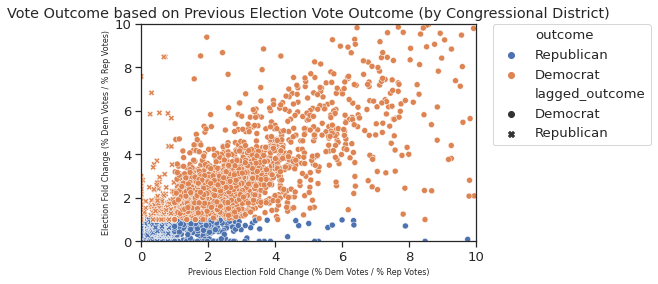

In [176]:
# Plot

sns.scatterplot(x="lagged_FC", y="foldchange", data=house_results, hue='outcome', legend=True, style = 'lagged_outcome')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Vote Outcome based on Previous Election Vote Outcome (by Congressional District)')
# Set x-axis label
plt.xlabel('Previous Election Fold Change (% Dem Votes / % Rep Votes)', fontsize=8)
# Set y-axis label
plt.ylabel('Election Fold Change (% Dem Votes / % Rep Votes)', fontsize=8)
plt.show()

In [225]:
# drop outcome and lagged outcome and label
#house_data = house_data.drop(['outcome', 'lagged_outcome', 'label'], axis = 1)

k_value_min = 1
k_value_max = 30

# creating list of integer k values betwwen k_value_min and k_value_max using linspace
k_list = np.linspace(k_value_min,k_value_max,num=20,dtype=int)

# Define the predictors and response for this baseline model
#X = house_data.drop(['foldchange'], axis = 1)
X = house_data[['lagged_FC', 'twice_lagged_FC', 'q2gdp', 'inc', 'juneapp']]
y = house_data['foldchange']


In [223]:
knn_optimizer(k_list, X, y)

The best k value is  17 with a cross val MSE of  3.4094379474176253
The R2 score for your model is 0.6002557591269009
The MSE for your model is 3.6528976732155574


#### Iterating on House KNN model

* add in historical polls
* scale data
* feature selection

In [234]:

# join 'historical_polls' on 'data'
house_data = house_data.rename({'year_x': 'year'}, axis=1) 
if 'year_y' in house_data.columns:
    house_data = house_data.drop(['year_y'], axis = 1)
house_data_with_polls = pd.merge(house_data, historical_polls, how='left', left_on=['year', 'state_po'], right_on=['cycle', 'state'])
imputer = KNNImputer(n_neighbors = 3)
house_data_with_polls  = pd.DataFrame(imputer.fit_transform(house_data_with_polls),columns = house_data_with_polls.columns)

scaler = StandardScaler()
# transform data via Standard Scaler
house_data_polls_X = house_data_with_polls
scaled_house_data = scaler.fit_transform(house_data_polls_X)
scaled_house_data = pd.DataFrame(scaled_house_data , columns = house_data_polls_X.columns)

scaled_house_data.head()


,year,state_po,district,total_votes,foldchange,lagged_FC,twice_lagged_FC,year_to_merge,label,deminc,...,term1,term2,dmargin,juneapp2,filter_.,predincvote,state,cycle,pct_D,pct_R
0,-1.666167,-1.720478,-0.882172,-0.537890,-0.545373,-0.274874,-0.256869,-1.592334,0.66475,-0.92313,...,-0.916849,0.916849,0.342861,0.752577,0.75828,-0.293211,0.309040,-0.748347,-0.113676,-0.938321
1,-1.666167,-1.720478,-0.781875,-0.548895,-0.499658,-0.003151,0.000129,-1.592334,0.66475,-0.92313,...,-0.916849,0.916849,0.342861,0.752577,0.75828,-0.293211,-0.875606,0.373194,0.522803,0.785117
2,-1.666167,-1.720478,-0.581281,-0.281123,0.626467,-0.098394,-0.123001,-1.592334,0.66475,-0.92313,...,-0.916849,0.916849,0.342861,0.752577,0.75828,-0.293211,0.572294,-0.997578,-0.503290,0.177028
3,-1.666167,-1.720478,-0.380686,-0.465049,-0.493869,-0.209977,-0.374488,-1.592334,0.66475,-0.92313,...,-0.916849,0.916849,0.342861,0.752577,0.75828,-0.293211,-1.165186,-0.249884,1.201841,-0.832569
4,-1.666167,-1.656251,-0.982470,-1.068556,-0.609388,-0.392911,-0.497070,-1.592334,0.66475,-0.92313,...,-0.916849,0.916849,0.342861,0.752577,0.75828,-0.293211,0.598620,-0.748347,0.796245,-1.306422


In [226]:
X = scaled_house_data[['lagged_FC', 'twice_lagged_FC', 'q2gdp', 'inc', 'juneapp']]
y = house_data_with_polls['foldchange']
knn_optimizer(k_list, X, y)

The best k value is  22 with a cross val MSE of  3.3764619969832537
The R2 score for your model is 0.6010596603402303
The MSE for your model is 3.6455515539437635


In [245]:
house_data_corr = scaled_house_data.corr()

foldchange_corr = house_data_corr.iloc[4]
pos_corr_feat = []
neg_corr_feat = []
for col in scaled_house_data.columns: 
    # get high positive correlation
    # get high negative correlation
    if foldchange_corr[col] > 0.1: 
        pos_corr_feat.append((col, foldchange_corr[col]))
    elif foldchange_corr[col]<-0.1:
        neg_corr_feat.append((col, foldchange_corr[col]))

print("High Positive Correlation features: ", pos_corr_feat)
print("High Negative Correlation features: ", neg_corr_feat)

High Positive Correlation features:  [('foldchange', 1.0), ('lagged_FC', 0.7798501268457335), ('twice_lagged_FC', 0.6414000182309318)]
High Negative Correlation features:  [('total_votes', -0.21974575983127292)]


In [244]:
X = scaled_house_data[['lagged_FC', 'twice_lagged_FC', 'total_votes']]
# also can do more features
y = house_data_with_polls['foldchange']
knn_optimizer(k_list, X, y)

The best k value is  20 with a cross val MSE of  3.238573254251683
The R2 score for your model is 0.6164029807237754
The MSE for your model is 3.5053429565514995


#### The House Logistic Regression Model (Predicting Win)

In [331]:
# Create binary outcome variable from foldchange

# Define the predictors and response for this baseline logistic regression model
#X = house_data.drop(['foldchange'], axis = 1)
X = house_data[['lagged_FC', 'twice_lagged_FC', 'q2gdp', 'inc', 'juneapp']]
y = np.where(house_data['foldchange'] > 1, 1, 0)  # The response is a binary variable indicating win (1 for Dem win and 0 for Rep win)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=109)


In [332]:
# Initialize the logistic regression model
logit_house = LogisticRegression(penalty='none', max_iter = 1000)

# Fit the model using the training set
logit_house.fit(X_train,y_train)

# Predict the y values for the training set and test set
y_train_pred = logit_house.predict(X_train)
y_test_pred = logit_house.predict(X_test)

# Calculate the accuracy score for the training set and test set
train_accuracy = accuracy_score(y_train,y_train_pred)
test_accuracy = accuracy_score(y_test,y_test_pred)

print(f"The classification accuracy for the training data is {train_accuracy:0.5f}.")
print(f"The classification accuracy for the test data is {test_accuracy:0.5f}.")

The classification accuracy for the training data is 0.84142.
The classification accuracy for the test data is 0.84181.


In [52]:
a

,year,label,deminc,popmargin,demvote,incvotemargin,incvote,inc1,eygdp,q2gdp,...,wonlost,inc,electapp,juneapp,term1,term2,dmargin,juneapp2,filter_.,predincvote
0,1948,48,1,4.6,52.3,4.60,52.30,0,3.9,7.6,...,Won,Yes,NaN,-4,0,1,4.6,Negative,Selected,50.467291
1,1952,52,1,-10.8,44.6,-10.80,44.60,0,5.4,0.4,...,Lost,No,-23.0,-26,0,1,-10.8,Negative,Not Selected,NaN
2,1956,56,0,-15.6,42.2,15.60,57.80,1,2.0,3.2,...,Won,Yes,48.0,55,1,0,-15.6,Positive,Selected,56.537339
3,1960,60,0,0.2,50.1,-0.20,49.90,0,0.9,-1.9,...,Lost,No,27.0,30,0,1,0.2,Positive,Not Selected,NaN
4,1964,64,1,22.6,61.3,22.60,61.30,1,5.2,4.7,...,Won,Yes,51.0,59,1,0,22.6,Positive,Selected,62.659529
5,1968,68,1,-0.8,49.6,-0.80,49.60,0,5.0,7.0,...,Lost,No,-9.0,-7,0,1,-0.8,Negative,Not Selected,NaN
6,1972,72,0,-23.6,38.2,23.60,61.80,1,6.9,9.8,...,Won,Yes,34.0,23,1,0,-23.6,Positive,Selected,60.179318
7,1976,76,0,2.2,51.1,-2.20,48.90,0,4.3,3.0,...,Lost,Yes,5.0,5,0,1,2.2,Positive,Selected,50.583111
8,1980,80,1,-10.6,44.7,-10.60,44.70,1,0.0,-7.9,...,Lost,Yes,-25.0,-27,1,0,-10.6,Negative,Selected,44.227115
9,1984,84,0,-18.4,40.8,18.40,59.20,1,5.6,7.1,...,Won,Yes,25.0,18,1,0,-18.4,Positive,Selected,58.790273


Text(0, 0.5, '% Democratic Vote (Popular)')

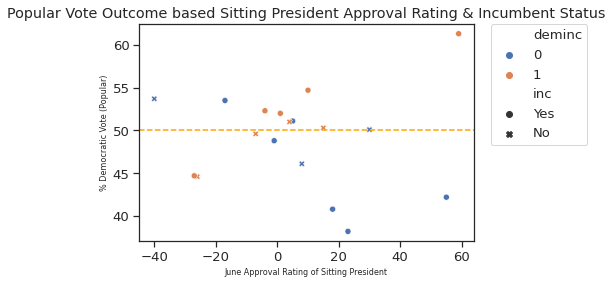

In [471]:
# Create visualization to illustrate relationship with approval rating
sns.scatterplot(x="juneapp", y="demvote", data=a, hue='deminc', legend=True, style = 'inc')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Popular Vote Outcome based Sitting President Approval Rating & Incumbent Status')
plt.axhline(50, ls='--', color = 'orange')
# Set x-axis label
plt.xlabel('June Approval Rating of Sitting President', fontsize=8)
# Set y-axis label
plt.ylabel('% Democratic Vote (Popular)', fontsize=8)

Text(0, 0.5, '% Democratic Vote (Popular)')

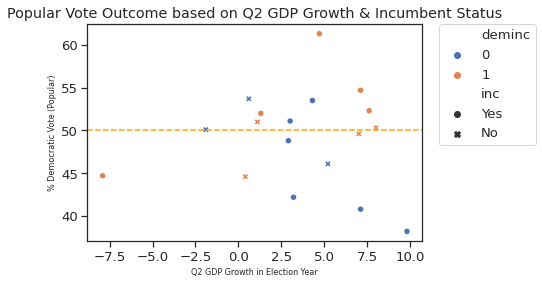

In [472]:
# Create visualization to illustrate relationship with gdp
sns.scatterplot(x="q2gdp", y="demvote", data=a, hue='deminc', legend=True, style = 'inc')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Popular Vote Outcome based on Q2 GDP Growth & Incumbent Status')
plt.axhline(50, ls='--', color = 'orange')
# Set x-axis label
plt.xlabel('Q2 GDP Growth in Election Year', fontsize=8)
# Set y-axis label
plt.ylabel('% Democratic Vote (Popular)', fontsize=8)

## Additional Visualizations: Demographic Data

In [473]:
a = pd.read_csv('abramowitz_data.csv')
acs_pop_density_2010 = pd.read_csv('acs_pop_density_2010.csv')
acs_2013_variables = pd.read_csv('acs_2013_variables.csv')
potus_results = pd.read_csv('potus_results_76_16.csv')
urbanicity_index = pd.read_csv('urbanicity_index.csv')

# Join together data sources at the state level
merge_1 = pd.merge(left=urbanicity_index, right=acs_2013_variables, left_on='state', right_on='state')


acs_pop_density_2010.head()
acs_2013_variables.head()
print(a.shape) #18, 2
acs_pop_density_2010.head() #state level, 52 x 4
acs_2013_variables.shape # 52 x 10
acs_pop_density_2010.head() # pop density included in 2013 set
results_16 = potus_results[potus_results['year']==2016]

# Merge datasources with 2016 outcomes
merge_3 = pd.merge(left=merge_1, right=results_16, left_on='state', right_on='state')
merge_3['outcome_2016'] = 'Democrat'
merge_3['outcome_2016'][merge_3['dem']<0.5] = 'Republican'

(18, 24)
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


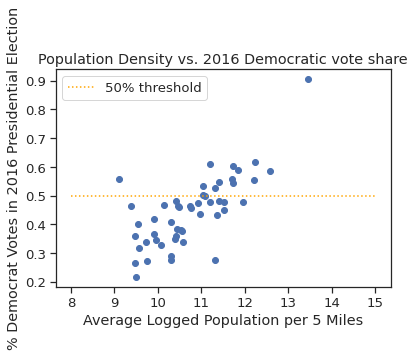

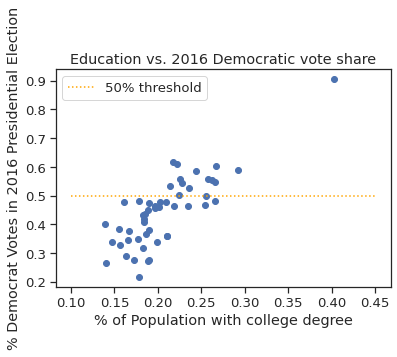

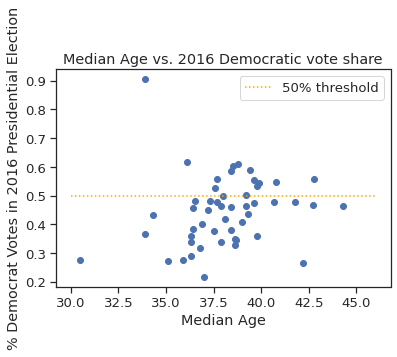

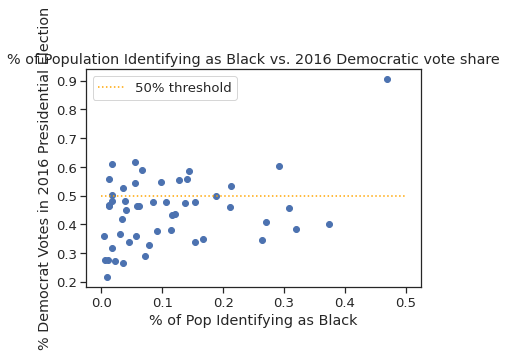

In [474]:
# Create some plots of demo data
merge_3.columns

# Plot 
plt.scatter(merge_3['average_log_pop_within_5_miles'], merge_3['dem'])
plt.hlines(0.5, xmin = 8, xmax = 15,linestyles='dotted',label='50% threshold',color= 'orange')
plt.xlabel('Average Logged Population per 5 Miles')
plt.ylabel('% Democrat Votes in 2016 Presidential Election')
plt.title('Population Density vs. 2016 Democratic vote share')
plt.legend()
plt.show()

# Plot 
plt.scatter(merge_3['college_pct'], merge_3['dem'])
plt.hlines(0.5, xmin = 0.1, xmax = 0.45,linestyles='dotted',label='50% threshold',color= 'orange')
plt.xlabel('% of Population with college degree')
plt.ylabel('% Democrat Votes in 2016 Presidential Election')
plt.title('Education vs. 2016 Democratic vote share')
plt.legend()
plt.show()

# Plot 
plt.scatter(merge_3['median_age'], merge_3['dem'])
plt.hlines(0.5, xmin = 30, xmax = 46,linestyles='dotted',label='50% threshold',color= 'orange')
plt.xlabel('Median Age')
plt.ylabel('% Democrat Votes in 2016 Presidential Election')
plt.title('Median Age vs. 2016 Democratic vote share')
plt.legend()
plt.show()

# Plot 
plt.scatter(merge_3['black_pct'], merge_3['dem'])
plt.hlines(0.5, xmin = 0, xmax = 0.5,linestyles='dotted',label='50% threshold',color= 'orange')
plt.xlabel('% of Pop Identifying as Black')
plt.ylabel('% Democrat Votes in 2016 Presidential Election')
plt.title('% of Population Identifying as Black vs. 2016 Democratic vote share')
plt.legend()
plt.show()



In [ ]:
# Plot population density vs. Education with Color by 2016 Election outcome
sns.scatterplot(x="average_log_pop_within_5_miles", y="college_pct", data=merge_3, hue='outcome_2016', legend=True, style = 'outcome_2016')
 
# Move the legend to an empty part of the plot
plt.title('Population Density vs. College Education with 2016 Vote Outcome')
# Set x-axis label
plt.xlabel('Avg Logged Population Within 5 Miles')
# Set y-axis label
plt.ylabel('% Population with College Degree')
plt.show()

## Predict on 2020 Data

In [61]:
twice_lagged_fc_2020 = outcome_data[outcome_data['year'] == 2012][['state', 'FC']]
lagged_fc_2020 = outcome_data[outcome_data['year'] == 2016][['state', 'FC']]

In [82]:
pres_polls

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,created_at,notes,url,stage,race_id,answer,candidate_id,candidate_name,candidate_party,pct
0,136283,72621,2020,Iowa,383,Public Policy Polling,NaN,NaN,Public Policy Polling,263.0,...,11/2/20 09:02,NaN,https://www.publicpolicypolling.com/wp-content...,general,6223,Biden,13256,Joseph R. Biden Jr.,DEM,49.0
1,136283,72621,2020,Iowa,383,Public Policy Polling,NaN,NaN,Public Policy Polling,263.0,...,11/2/20 09:02,NaN,https://www.publicpolicypolling.com/wp-content...,general,6223,Trump,13254,Donald Trump,REP,48.0
2,136322,72647,2020,Pennsylvania,461,Susquehanna Polling & Research Inc.,NaN,NaN,Susquehanna Polling & Research Inc.,326.0,...,11/2/20 12:49,NaN,https://www.realclearpolitics.com/docs/2020/Su...,general,6249,Biden,13256,Joseph R. Biden Jr.,DEM,48.4
3,136322,72647,2020,Pennsylvania,461,Susquehanna Polling & Research Inc.,NaN,NaN,Susquehanna Polling & Research Inc.,326.0,...,11/2/20 12:49,NaN,https://www.realclearpolitics.com/docs/2020/Su...,general,6249,Trump,13254,Donald Trump,REP,49.2
4,136322,72647,2020,Pennsylvania,461,Susquehanna Polling & Research Inc.,NaN,NaN,Susquehanna Polling & Research Inc.,326.0,...,11/2/20 12:49,NaN,https://www.realclearpolitics.com/docs/2020/Su...,general,6249,Jorgensen,14611,Jo Jorgensen,LIB,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16433,92081,57026,2020,Ohio,383,Public Policy Polling,1363,DEM (partisan),Public Policy Polling,263.0,...,12/6/18 14:45,NaN,https://www.cleveland.com/politics/2018/11/thi...,general,6246,Trump,13254,Donald Trump,REP,46.0
16434,92082,57026,2020,Ohio,383,Public Policy Polling,1363,DEM (partisan),Public Policy Polling,263.0,...,12/6/18 14:46,NaN,https://www.cleveland.com/politics/2018/11/thi...,general,6246,Warren,13258,Elizabeth Warren,DEM,43.0
16435,92082,57026,2020,Ohio,383,Public Policy Polling,1363,DEM (partisan),Public Policy Polling,263.0,...,12/6/18 14:46,NaN,https://www.cleveland.com/politics/2018/11/thi...,general,6246,Trump,13254,Donald Trump,REP,49.0
16436,92078,57025,2020,NaN,399,Rasmussen Reports/Pulse Opinion Research,NaN,NaN,Rasmussen Reports/Pulse Opinion Research,277.0,...,12/6/18 14:40,NaN,http://www.rasmussenreports.com/public_content...,general,6210,Obama,13253,Michelle Obama,DEM,50.0


In [376]:
# Replicate poll data cleaning
pres_polls = pd.read_csv('president_polls.csv')

# Calculate aggregate means grouped by state, election cycle, and candidate
pres_polls = pres_polls.groupby(['state', 'cycle', 'candidate_name'], as_index=False).mean()

# Drop rows with invalid state names
states = sorted([state for state in set(pres_polls['state'].to_numpy()) if state not in ['ME-1','ME-2','NE-1','NE-2','NE-3','National']])
pres_polls = pres_polls[pres_polls.state.isin(states)]

# Drop rows with non-democratic or republican nominees (remove independent candidates)
presidential_nominees = {'Joseph R. Biden Jr.': 'D', 'Donald Trump': 'R'}
pres_polls = pres_polls[pres_polls.candidate_name.isin(list(presidential_nominees.keys()))]

# Select relevant columns
pres_polls = pres_polls[['state', 'cycle', 'candidate_name', 'pct']]

# Duplicate the percentage favoring column and create separate columns for democratic and republican
pres_polls['pct_R'] = pres_polls['pct']
pres_polls = pres_polls.rename(columns = {'pct': 'pct_D'})

# Create lists of democratic and republican nominees
democratic_nominees = [k for k,v in presidential_nominees.items() if v=='D']
republican_nominees = [k for k,v in presidential_nominees.items() if v=='R']

# Remove democrat values from the republican column and vice versa
pres_polls.pct_D = pres_polls.pct_D.where(pres_polls.candidate_name.isin(democratic_nominees))
pres_polls.pct_R = pres_polls.pct_R.where(pres_polls.candidate_name.isin(republican_nominees))

# Remove the candidate name column and collapse dataframe by grouping by election cycle
pres_polls.drop('candidate_name', axis=1, inplace=True)
pres_polls = pres_polls.groupby(['state', 'cycle'])[['pct_D', 'pct_R']].first().reset_index()

pres_polls['poll_FC'] = pres_polls['pct_D']/pres_polls['pct_R']  # Greater than 1 is a win for Democrat
#pres_polls


/opt/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (6,22,25,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [377]:

#pres_polls['state'] = pres_polls['state'].replace(state_fips)
#pres_polls['state'] = pres_polls['state'].replace(str(state_name_fips))
#pres_polls
state_crosswalk = pd.read_csv('state_name_crosswalk.csv')
# join 'historical_polls' on 'data'
polls_w_names = pres_polls.merge(state_crosswalk, how = 'inner', left_on=['state'], right_on = ['State'])
#polls_w_names


In [378]:
# Read in X data for 2020
pres_2020_x = pd.read_csv('2020_x_data_pres.csv')
pres_2020_x.head()

# Merge in lagged FC data
temp1 = pres_2020_x.merge(twice_lagged_fc_2020, how = 'left', left_on=['state'], right_on = ['state'])
temp2 = temp1.merge(lagged_fc_2020, how = 'left', left_on=['state'], right_on = ['state'])
temp2 = temp2.rename(columns={"FC_x": "twice_lagged_FC", "FC_y": "lagged_FC"})
temp2.head()

# Now pull in 2020 poll FC
pres_X_full = temp2.merge(polls_w_names, how = 'left', left_on=['state'], right_on = ['Code'])
pres_X_full = pres_X_full.dropna()
pres_X_full


,state_x,2019_Q3,2019_Q4,q1gdp,q2gdp,inc,juneapp,twice_lagged_FC,lagged_FC,state_y,cycle,pct_D,pct_R,poll_FC,State,Abbrev,Code
0,AK,3.6,-0.5,-6.0,-33.8,1.0,-15.0,0.744735,0.712749,Alaska,2020.0,44.297069,52.000806,0.851853,Alaska,Alaska,AK
1,AL,2.8,1.3,-3.2,-29.6,1.0,-15.0,0.633554,0.553419,Alabama,2020.0,39.128833,57.996000,0.674682,Alabama,Ala.,AL
2,AR,1.8,1.9,-4.0,-27.9,1.0,-15.0,0.608896,0.555570,Arkansas,2020.0,39.125098,58.627255,0.667353,Arkansas,Ark.,AR
3,AZ,4.7,4.9,-3.2,-25.3,1.0,-15.0,0.831053,0.927153,Arizona,2020.0,49.153989,45.492257,1.080491,Arizona,Ariz.,AZ
4,CA,1.6,6.6,-4.3,-31.5,1.0,-15.0,1.622800,1.952310,California,2020.0,61.357470,33.864892,1.811831,California,Calif.,CA
5,CO,6.0,2.5,-1.3,-28.1,1.0,-15.0,1.116312,1.113420,Colorado,2020.0,55.847368,40.752941,1.370389,Colorado,Colo.,CO
6,CT,0.6,1.9,-6.0,-31.1,1.0,-15.0,1.425570,1.333262,Connecticut,2020.0,60.850000,34.921538,1.742478,Connecticut,Conn.,CT
7,DC,1.7,2.7,-1.2,-20.4,1.0,-15.0,12.490997,22.229820,District of Columbia,2020.0,87.973333,9.691458,9.077409,District of Columbia,D.C.,DC
8,DE,-0.4,1.7,-11.4,-21.9,1.0,-15.0,1.465906,1.272656,Delaware,2020.0,62.834902,35.797273,1.755299,Delaware,Del.,DE
9,FL,3.0,3.4,-4.3,-30.1,1.0,-15.0,1.017848,0.975549,Florida,2020.0,48.754155,46.337287,1.052158,Florida,Fla.,FL


In [379]:
# Limit X data to just vars included in model
# Define the predictors and response for this baseline logistic regression model
X_2020 = pres_X_full[['lagged_FC', 'twice_lagged_FC', 'q1gdp', 'inc', 'juneapp', 'poll_FC']]
# Do q1 gdp since it was so whack in q2
X_2020 = X_2020.rename(columns={"q1gdp": "q2gdp"})
#X_train
#X_2020

y_pred_2020 = logit_ridge.predict(X_2020)

In [380]:
states = np.array(pres_X_full.state_x)

In [381]:
predictions = pd.DataFrame({'state': states, 'prediction': y_pred_2020}, columns=['state', 'prediction'])
predictions
predictions.to_csv(path_or_buf="Presidential_Predictions.csv", index = False, header=True)


elec_college_votes = pd.read_csv('elec_college_votes.csv')
ec = elec_college_votes.merge(state_crosswalk, how = 'left', left_on=['state'], right_on = ['State'])[['Code', 'votes']]
#ec
pred_with_votes = predictions.merge(ec, how = 'left', left_on=['state'], right_on = ['Code'])
pred_with_votes.groupby('prediction').sum()


,votes
prediction,
0,325
1,213


try KNN pres model to predict results

In [382]:
pres_X_full.head()

,state_x,2019_Q3,2019_Q4,q1gdp,q2gdp,inc,juneapp,twice_lagged_FC,lagged_FC,state_y,cycle,pct_D,pct_R,poll_FC,State,Abbrev,Code
0,AK,3.6,-0.5,-6.0,-33.8,1.0,-15.0,0.744735,0.712749,Alaska,2020.0,44.297069,52.000806,0.851853,Alaska,Alaska,AK
1,AL,2.8,1.3,-3.2,-29.6,1.0,-15.0,0.633554,0.553419,Alabama,2020.0,39.128833,57.996000,0.674682,Alabama,Ala.,AL
2,AR,1.8,1.9,-4.0,-27.9,1.0,-15.0,0.608896,0.555570,Arkansas,2020.0,39.125098,58.627255,0.667353,Arkansas,Ark.,AR
3,AZ,4.7,4.9,-3.2,-25.3,1.0,-15.0,0.831053,0.927153,Arizona,2020.0,49.153989,45.492257,1.080491,Arizona,Ariz.,AZ
4,CA,1.6,6.6,-4.3,-31.5,1.0,-15.0,1.622800,1.952310,California,2020.0,61.357470,33.864892,1.811831,California,Calif.,CA


In [383]:
y20_knn_pred = knn_pres_model.predict(X_2020)

predictions_knn_pres = pd.DataFrame({'state': states, 'KNN_prediction': y20_knn_pred}, columns=['state', 'KNN_prediction'])
predictions_knn_pres['KNN_result'] = np.where(predictions_knn_pres['KNN_prediction']>1, 1, 0)
predictions_knn_pres['KNN_result'].value_counts()
# predictions.to_csv(path_or_buf="Presidential_Predictions.csv", index = False, header=True)


# ec = elec_college_votes.merge(state_crosswalk, how = 'left', left_on=['state'], right_on = ['State'])[['Code', 'votes']]
# #ec
#predictions_knn_pres
knn_pred_with_votes = predictions_knn_pres.merge(ec, how = 'left', left_on=['state'], right_on = ['Code'])
knn_pred_with_votes.groupby('KNN_result').sum()
knn_pred_with_votes


,state,KNN_prediction,KNN_result,Code,votes
0,AK,1.064677,0,AK,3
1,AL,1.867792,1,AL,9
2,AR,1.867792,1,AR,6
3,AZ,2.107130,1,AZ,11
4,CA,1.867792,1,CA,55
5,CO,2.107130,1,CO,9
6,CT,0.848468,0,CT,7
7,DC,10.000000,1,DC,3
8,DE,0.848468,0,DE,3
9,FL,1.867792,1,FL,29


#### Make Maps of our 2020 Presidential Prediction

In [384]:
# get 2020 pres results

actual_20_pres = pd.read_csv("/home/jovyan/work/2020_pres_results-cook_political.csv")
actual_20_pres['rep_votes'] = actual_20_pres['rep_votes'].str.replace(',', '').astype(float)
actual_20_pres['dem_votes'] = actual_20_pres['dem_votes'].str.replace(',', '').astype(float)
actual_20_pres['result'] = np.where(actual_20_pres.rep_votes>actual_20_pres.dem_votes, 0, 1)
actual_20_merge = actual_20_pres[['state','result']]

us_shape_pres20 = pd.merge(us_shape_pres16, pred_with_votes, left_on = ['STATE_ABBR'],right_on=['state'] )
us_shape_pres20 = pd.merge(us_shape_pres20, predictions_knn_pres, left_on = ['STATE_ABBR'],right_on=['state'] )
us_shape_pres20 = pd.merge(us_shape_pres20, actual_20_merge, how = 'left', left_on = ['STATE_NAME'], right_on = ['state'])

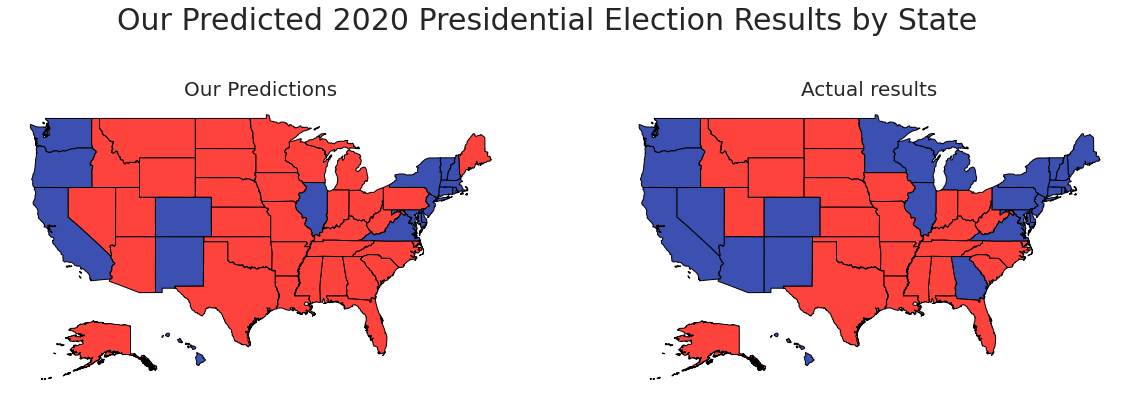

In [385]:
color_mapping = {1: '#3C50B1', 0:'#FE433C'}

fig, (gax1, gax2) = plt.subplots(1, 2, figsize = (20, 7))
gax1.set_axis_off()
gax2.set_axis_off()

gax1.set_title("Our Predictions", fontsize = 20)
gax2.set_title("Actual results", fontsize = 20)
gax1 = us_shape_pres20.plot(ax=gax1 , edgecolor='black', color = us_shape_pres20.prediction.map(color_mapping))
#gax1 = us_shape_pres20.plot(ax=gax1 , edgecolor='black', color = us_shape_pres20.KNN_result.map(color_mapping))
gax2 = us_shape_pres20.plot(ax = gax2, edgecolor = 'black', color = us_shape_pres20.result_y.map(color_mapping))
fig.suptitle("Our Predicted 2020 Presidential Election Results by State", fontsize = 30)

# custom_lines = [Line2D([0], [0], color="#FE433C", lw=4),
#                  Line2D([0], [0], color='#3C50B1', lw=4)]

# gax1.legend(custom_lines, ['Trump','Biden'])


plt.show()

In [447]:

def get_FPR_FNR(y, y_pred):
    TP, FP, TN, FN = 0.0, 0.0, 0.0, 0.0

    assert(len(y) == len(y_pred))
    for i in range(len(y)): 
        if y[i]==y_pred[i]==1:
           TP += 1.0
        if y_pred[i]==1 and y[i]==0:
           FP += 1.0
        if y[i]==y_pred[i]==0:
           TN += 1.0
        if y_pred[i]==0 and y[i]==1:
           FN += 1.0

    FPR = FP/(FP+TN)
    FNR = FN/(FN + TP)

    return(FPR, FNR)

get_FPR_FNR(us_shape_pres20.result_y, us_shape_pres20.prediction)

In [386]:
# Accuracy Score
pres_accuracy = accuracy_score(us_shape_pres20['result_y'],us_shape_pres20['prediction'])
print(f'Ridge Accuracy Score: Presidential Election: {round(pres_accuracy,4)}')
# This isn't actually too bad given our train/test

pres_accuracy_knn = accuracy_score(us_shape_pres20['result_y'],us_shape_pres20['KNN_result'])
print(f'KNN Accuracy Score: Presidential Election: {round(pres_accuracy_knn,4)}')


Ridge Accuracy Score: Presidential Election: 0.8431
KNN Accuracy Score: Presidential Election: 0.5098


In [468]:
# battleground states
battleground = ['Arizona', 'Florida', 'Georgia', 'Iowa', 'Maine', 'Michigan', 'Minnesota', 'Nebraska', 'Nevada', 'New Hampshire', 'North Carolina', 'Ohio', 'Pennsylvania', 'Texas', 'Wisconsin']

# non battleground states
nonbattleground = ["Alabama", "Alaska", "Arkansas", "California", "Colorado", "Connecticut",
"Delaware", "District of Columbia", "Hawaii", "Idaho", "Illinois", "Indiana",
"Kansas", "Kentucky", "Louisiana", "Maryland", "Massachusetts", "Mississippi", "Missouri", 
"Montana", "New Jersey", "New Mexico", "New York", "North Dakota", "Oklahoma", 
"Oregon", "Rhode Island", "South Carolina", "Tennessee", "Utah", "Vermont", 
"Virginia", "Washington", "West Virginia", "Wyoming"]

battle_df= us_shape_pres20[us_shape_pres20.STATE_NAME.isin(battleground)][['STATE_NAME','prediction', 'result_y']]
nonbattle_df= us_shape_pres20[us_shape_pres20.STATE_NAME.isin(nonbattleground)][['STATE_NAME','prediction', 'result_y']]

def get_precision_recall(y, y_pred):
    TP, FP, TN, FN = 0.0, 0.0, 0.0, 0.0

    assert(len(y) == len(y_pred))
    for i in range(len(y)): 
        if y[i]==y_pred[i]==1:
           TP += 1.0
        if y_pred[i]==1 and y[i]==0:
           FP += 1.0
        if y[i]==y_pred[i]==0:
           TN += 1.0
        if y_pred[i]==0 and y[i]==1:
           FN += 1.0

    recall = TP/(TP + FN)
    precision = TP/(TP + FP)
    accuracy = (TP + TN)/ (TP + FP + TN + FN)

    return(round(recall, 4), round(precision, 4), round(accuracy, 4))

print("Battleground states- (Recall, Precision, Accuracy)", get_precision_recall(battle_df['result_y'].values, battle_df['prediction'].values))
print("Non-Battleground states- (Recall, Precision, Accuracy)", get_precision_recall(nonbattle_df['result_y'].values, nonbattle_df['prediction'].values))


Battleground states- (Precision, Recall, Accuracy) (0.1111, 1.0, 0.4667)
Non-Battleground states- (Precision, Recall, Accuracy) (1.0, 1.0, 1.0)


## Try Predicting House

In [400]:
house_results.head()

,year,state_po,district,total_votes,foldchange,lagged_FC,twice_lagged_FC,year_to_merge
0,1976,AL,1,157170.0,0.599509,NaN,NaN,1976
1,1976,AL,2,156362.0,0.735969,NaN,NaN,1976
2,1976,AL,4,176022.0,4.097478,NaN,NaN,1976
3,1976,AL,6,162518.0,0.753249,NaN,NaN,1976
4,1976,AK,0,118208.0,0.408423,NaN,NaN,1976


In [420]:
# Grab unique state and districts from house_results
# Can just join onto same state data for things other than FC and poll outcomes
# variables needed: 
# X = house_data[['lagged_FC', 'twice_lagged_FC', 'q2gdp', 'inc', 'juneapp']]
#house_data[house_data['year']==2018]
#house_results[house_results['year']==2016].shape

# filter for 2018: FC --> lagged_FC, lagged_FC --> twice_lagged_FC
house_x = house_results[house_results['year']==2018]
#house_x.drop(['twice_lagged_FC'], axis=1, inplace=True)
#house_x.rename(columns={'foldchange': 'lagged_FC', 'lagged_FC':'twice_lagged_FC'}, inplace=True)

# join pres_2020_x on house_results
pres_2020_x = pd.read_csv('2020_x_data_pres.csv')
house_x = house_x.merge(pres_2020_x, how='left', left_on=['state_po'], right_on=['state'])
house_x.head()

# Now pull in 2020 poll FC
house_x = house_x.merge(polls_w_names, how='left', left_on=['state_po'], right_on=['Code'])
house_x = house_x.dropna()

house_y = house_x['foldchange']

house_x

,year,state_po,district,total_votes,foldchange,lagged_FC,twice_lagged_FC,year_to_merge,state_x,2019_Q3,...,inc,juneapp,state_y,cycle,pct_D,pct_R,poll_FC,State,Abbrev,Code
0,2018,AL,1,242617.0,0.582309,0.000100,0.465294,2016,AL,2.8,...,1.0,-15.0,Alabama,2020,39.128833,57.996000,0.674682,Alabama,Ala.,AL
1,2018,AL,2,226230.0,0.625948,0.830991,0.483559,2016,AL,2.8,...,1.0,-15.0,Alabama,2020,39.128833,57.996000,0.674682,Alabama,Ala.,AL
2,2018,AL,3,231915.0,0.568424,0.492022,0.510014,2016,AL,2.8,...,1.0,-15.0,Alabama,2020,39.128833,57.996000,0.674682,Alabama,Ala.,AL
3,2018,AL,4,230969.0,0.252324,0.000100,0.000100,2016,AL,2.8,...,1.0,-15.0,Alabama,2020,39.128833,57.996000,0.674682,Alabama,Ala.,AL
4,2018,AL,5,260673.0,0.637408,0.497133,0.000100,2016,AL,2.8,...,1.0,-15.0,Alabama,2020,39.128833,57.996000,0.674682,Alabama,Ala.,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,2018,WI,2,317295.0,11.000000,2.205161,2.170644,2016,WI,0.2,...,1.0,-15.0,Wisconsin,2020,50.058843,43.855082,1.141460,Wisconsin,Wis.,WI
446,2018,FL,10,1.0,1.000000,1.000000,1.846462,2016,FL,3.0,...,1.0,-15.0,Florida,2020,48.754155,46.337287,1.052158,Florida,Fla.,FL
447,2018,FL,14,1.0,1.000000,1.000000,1.616915,2016,FL,3.0,...,1.0,-15.0,Florida,2020,48.754155,46.337287,1.052158,Florida,Fla.,FL
448,2018,FL,21,1.0,1.000000,11.000000,11.000000,2016,FL,3.0,...,1.0,-15.0,Florida,2020,48.754155,46.337287,1.052158,Florida,Fla.,FL


In [421]:
# Limit X data to just vars included in model
# Define the predictors and response for this baseline logistic regression model
X_2020_house = house_x[['lagged_FC', 'twice_lagged_FC', 'q1gdp', 'inc', 'juneapp', 'poll_FC']]
# Do q1 gdp since it was so whack in q2
X_2020_house = X_2020_house.rename(columns={"q1gdp": "q2gdp"})
#X_train
#X_2020

y_2020_house_pred = logit_ridge.predict(X_2020_house)

In [427]:
states = np.array(house_x.state_x)
districts = np.array(house_x.district)

In [429]:
house_predictions = pd.DataFrame({'state': states, 'district': districts, 'prediction': y_2020_house_pred}, columns=['state', 'district', 'prediction'])
house_predictions.to_csv(path_or_buf="House_Predictions.csv", index = False, header=True)

In [437]:
house_predictions['state'] = house_predictions['state'].replace(state_fips)

#### setup for House predictions and results maps

In [438]:
cong20_shape = cong18_shape.drop(['state_fips', 'district', 'rep_candidate', 'rep_votes', 'dem_candidate', 'dem_votes', 'total_votes', 'rep','Result'], axis = 1)
actual_20_cong = pd.read_csv("/home/jovyan/work/2020_house_results-cook_political.csv")
actual_20_cong_merge = actual_20_cong[['state', 'CD#','called']]
actual_20_cong_merge['results']= np.where(actual_20_cong_merge.called == "R", 0, 1)
actual_20_cong_merge = actual_20_cong_merge.dropna(subset=['CD#'])
actual_20_cong_merge['CD#'] = actual_20_cong_merge['CD#'].replace({'AL': 0})
actual_20_cong_merge['CD#'] = actual_20_cong_merge['CD#'].astype(int)
state_name_to_fips = us_shape_pres20[['STATE_NAME', 'STATE_FIPS']]
state_name_to_fips.STATE_FIPS = state_name_to_fips.STATE_FIPS.astype(int)

cong20_shape = pd.merge(cong20_shape, state_name_to_fips, left_on = ['STATEFP'], right_on = ['STATE_FIPS'])
cong20_shape = pd.merge(cong20_shape, actual_20_cong_merge, left_on = ['STATE_NAME', 'CD116FP'], right_on = ['state', 'CD#'])
cong20_shape = pd.merge(cong20_shape, house_predictions, left_on = ['STATE_FIPS', 'CD#'], right_on = ['state', 'district']) 

cong20_shape.head()

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/venv/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,STATEFP,CD116FP,AFFGEOID,GEOID,LSAD,CDSESSN,ALAND,AWATER,geometry,STATE_NAME,STATE_FIPS,state_x,CD#,called,results,state_y,district,prediction
0,34,10,5001600US3410,3410,C2,116,196397289,12474852,"POLYGON ((-74.30292 40.60868, -74.24235 40.691...",New Jersey,34,New Jersey,10,D,1,34,10,1
1,34,6,5001600US3406,3406,C2,116,557571516,503799396,"POLYGON ((-74.46329 40.59919, -74.44172 40.597...",New Jersey,34,New Jersey,6,D,1,34,6,1
2,34,9,5001600US3409,3409,C2,116,246870811,19480622,"POLYGON ((-74.19640 40.94647, -74.17114 40.977...",New Jersey,34,New Jersey,9,D,1,34,9,1
3,34,7,5001600US3407,3407,C2,116,2512156343,47085986,"POLYGON ((-75.19261 40.71587, -75.17748 40.764...",New Jersey,34,New Jersey,7,D,1,34,7,1
4,34,12,5001600US3412,3412,C2,116,1067381022,18504392,"MULTIPOLYGON (((-74.46329 40.59919, -74.42440 ...",New Jersey,34,New Jersey,12,D,1,34,12,1


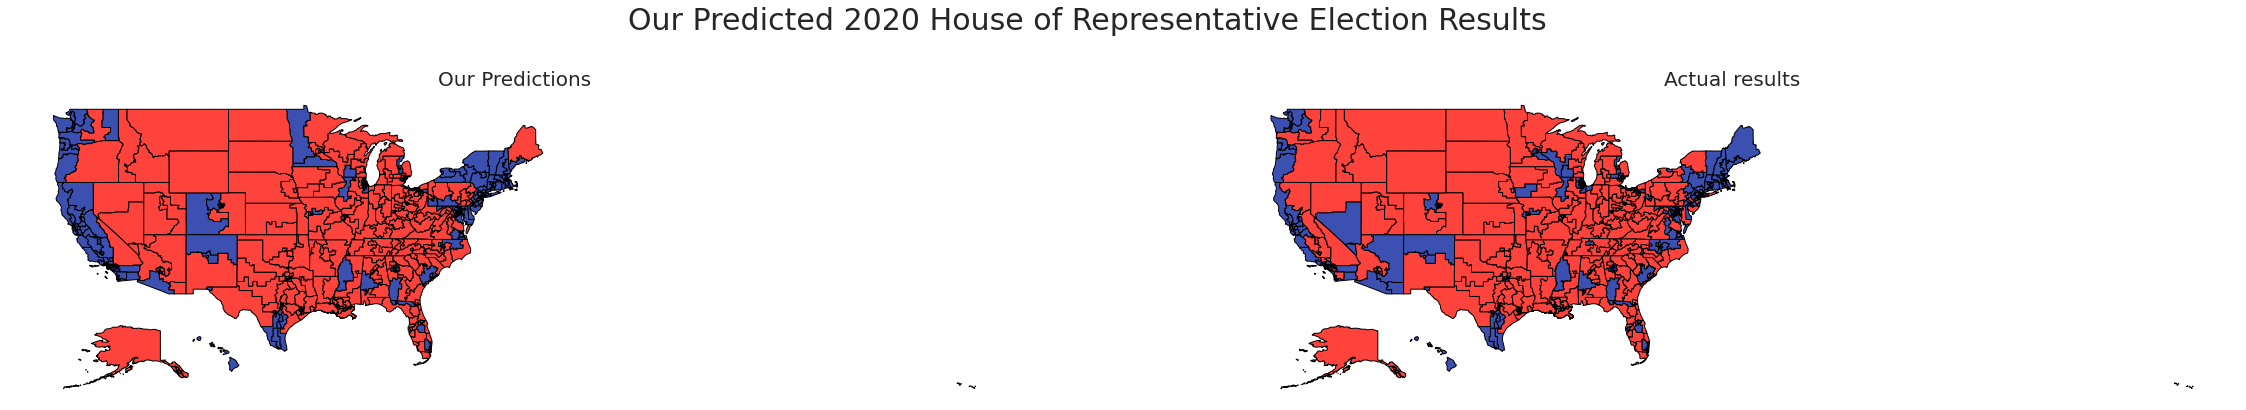

In [470]:
color_mapping = {1: '#3C50B1', 0:'#FE433C'}

fig, (gax1, gax2) = plt.subplots(1, 2, figsize = (40, 7))
gax1.set_axis_off()
gax2.set_axis_off()

gax1.set_title("Our Predictions", fontsize = 20)
gax2.set_title("Actual results", fontsize = 20)
gax1 = cong20_shape.plot(ax = gax1, edgecolor = 'black', color = cong20_shape.prediction.map(color_mapping))
gax2 = cong20_shape.plot(ax = gax2, edgecolor = 'black', color = cong20_shape.results.map(color_mapping))
fig.suptitle("Our Predicted 2020 House of Representative Election Results", fontsize = 30)

# custom_lines = [Line2D([0], [0], color="#FE433C", lw=4),
#                  Line2D([0], [0], color='#3C50B1', lw=4)]

# gax1.legend(custom_lines, ['Trump','Biden'])

plt.savefig('congress_comparison.png')
plt.show()

In [440]:
cong20_shape

,STATEFP,CD116FP,AFFGEOID,GEOID,LSAD,CDSESSN,ALAND,AWATER,geometry,STATE_NAME,STATE_FIPS,state_x,CD#,called,results,state_y,district,prediction
0,34,10,5001600US3410,3410,C2,116,196397289,12474852,"POLYGON ((-74.30292 40.60868, -74.24235 40.691...",New Jersey,34,New Jersey,10,D,1,34,10,1
1,34,6,5001600US3406,3406,C2,116,557571516,503799396,"POLYGON ((-74.46329 40.59919, -74.44172 40.597...",New Jersey,34,New Jersey,6,D,1,34,6,1
2,34,9,5001600US3409,3409,C2,116,246870811,19480622,"POLYGON ((-74.19640 40.94647, -74.17114 40.977...",New Jersey,34,New Jersey,9,D,1,34,9,1
3,34,7,5001600US3407,3407,C2,116,2512156343,47085986,"POLYGON ((-75.19261 40.71587, -75.17748 40.764...",New Jersey,34,New Jersey,7,D,1,34,7,1
4,34,12,5001600US3412,3412,C2,116,1067381022,18504392,"MULTIPOLYGON (((-74.46329 40.59919, -74.42440 ...",New Jersey,34,New Jersey,12,D,1,34,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,2,0,5001600US0200,0200,C1,116,1478839695958,245481577452,"MULTIPOLYGON (((-15.94572 22.49294, -15.91526 ...",Alaska,2,Alaska,0,R,0,2,0,0
520,38,0,5001600US3800,3800,C1,116,178707534813,4403267548,"POLYGON ((-104.04874 48.99988, -103.37547 48.9...",North Dakota,38,North Dakota,0,R,0,38,0,0
521,50,0,5001600US5000,5000,C1,116,23874175944,1030416650,"POLYGON ((-73.41632 44.09942, -73.39987 44.152...",Vermont,50,Vermont,0,D,1,50,0,1
522,56,0,5001600US5600,5600,C1,116,251458544898,1867670745,"POLYGON ((-111.05689 44.86666, -111.04432 45.0...",Wyoming,56,Wyoming,0,R,0,56,0,0


In [445]:
# Accuracy Score
cong_accuracy = accuracy_score(cong20_shape['results'],cong20_shape['prediction'])
print(f'Final Predictions Accuracy Score for Congressional Election: {round(cong_accuracy,4)}')

print("False Positive Rate, False Negative Rate", get_FPR_FNR(cong20_shape['results'],cong20_shape['prediction']))

Final Predictions Accuracy Score for Congressional Election: 0.8683
False Positive Rate, False Negative Rate (0.10380622837370242, 0.16595744680851063)


In [479]:
len(house_data.year_x.unique()) #9735 #22

22